# Initial Data Analysis (IDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Data Importing

In [2]:
df = pd.read_csv('./data/transactions.csv')

### Data Checking

In [3]:
print(df)
# display(df)

                              transaction_id user_id  transaction_amount transaction_date merchant_id  \
0       4a71b7d1-34fa-45cf-b40a-a730d16ce617  U10578             23500.0       2024-05-09      M04936   
1       b29665c0-8373-4ec1-a121-a041c77ffb51  U08353            150500.0       2024-05-30      M06359   
2       3e32187b-b374-4f1b-a64e-b1ebcc856563  U04564             65800.0       2024-03-08      M01710   
3       df8ad42e-aaf6-46d2-8d8f-1e291a4554bd  U22797             45600.0       2024-05-14      M02852   
4       334468df-4d71-4e4a-935c-32c17c306611  U18053              8500.0       2024-04-09      M00722   
...                                      ...     ...                 ...              ...         ...   
278927  77e14f67-1672-4199-96de-b51628e79513  U13928             35300.0       2024-05-15      M05011   
278928  22d95830-2c41-4b3a-9a12-bde3d28a86a0  U22337             30400.0       2024-05-01      M03137   
278929  f12b9af5-d3e5-48d5-98e6-1c0649cf20ad  U08210   

In [4]:
print("Rows:", df.shape[0], "\n")

print("Columns:", df.shape[1])
for i in df.columns:
    print(f'- {i} ({df[i].dtype})')

Rows: 278932 

Columns: 17
- transaction_id (object)
- user_id (object)
- transaction_amount (float64)
- transaction_date (object)
- merchant_id (object)
- merchant_name (object)
- merchant_category_id (int64)
- geo_location (object)
- payment_method (object)
- user_agent (object)
- loyalty_program (object)
- discount_applied (object)
- promo_amount (float64)
- transaction_notes (object)
- merchant_rating (int64)
- transaction_status (object)
- is_refunded (object)


In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278932 entries, 0 to 278931
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   transaction_id        278932 non-null  object 
 1   user_id               278932 non-null  object 
 2   transaction_amount    278932 non-null  float64
 3   transaction_date      278932 non-null  object 
 4   merchant_id           278932 non-null  object 
 5   merchant_name         278932 non-null  object 
 6   merchant_category_id  278932 non-null  int64  
 7   geo_location          278932 non-null  object 
 8   payment_method        278932 non-null  object 
 9   user_agent            278932 non-null  object 
 10  loyalty_program       278932 non-null  object 
 11  discount_applied      278932 non-null  object 
 12  promo_amount          278932 non-null  float64
 13  transaction_notes     278932 non-null  object 
 14  merchant_rating       278932 non-null  int64  
 15  

None

In [6]:
display(df.isnull().sum())

transaction_id          0
user_id                 0
transaction_amount      0
transaction_date        0
merchant_id             0
merchant_name           0
merchant_category_id    0
geo_location            0
payment_method          0
user_agent              0
loyalty_program         0
discount_applied        0
promo_amount            0
transaction_notes       0
merchant_rating         0
transaction_status      0
is_refunded             0
dtype: int64

### Data Description

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric Columns:" , numeric_cols)
# display(df[["transaction_amount", "promo_amount"]].describe().T)

Numeric Columns: ['transaction_amount', 'merchant_category_id', 'promo_amount', 'merchant_rating']


In [8]:
categorical_cols = [
    "user_id",
    "merchant_id",
    "merchant_name",
    "merchant_category_id",
    "payment_method",
    "user_agent",
    "loyalty_program",
    "discount_applied",
    "transaction_status",
    "is_refunded",
]

print("Categorical Columns:", categorical_cols)
for col in categorical_cols:
    if col in df.columns:
        pass
        # display(df[col].value_counts())

Categorical Columns: ['user_id', 'merchant_id', 'merchant_name', 'merchant_category_id', 'payment_method', 'user_agent', 'loyalty_program', 'discount_applied', 'transaction_status', 'is_refunded']


### Data Parsing

#### transaction_date

In [9]:
# Parse transaction_date and Add Temporal Features

# Convert to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

# Check for issues
n_missing_dates = df["transaction_date"].isna().sum()
print(f"Number of Issues: {n_missing_dates}")

# Add Temporal Features
df["date"] = df["transaction_date"].dt.date
# df["hour"] = df["transaction_date"].dt.hour
df["day_of_week"] = df["transaction_date"].dt.dayofweek  # Monday=0, Sunday=6
df["is_weekend"] = df["day_of_week"].isin([5, 6]).map({True: "yes", False: "no"})
df["month"] = df["transaction_date"].dt.month

iso_calendar = df["transaction_date"].dt.isocalendar()
df["week_of_year"] = iso_calendar["week"]

Number of Issues: 0


In [10]:
print("\ntransaction_date and Temporal Features:")
display(df[["transaction_date", "date", "day_of_week", "is_weekend", "month", "week_of_year"]].head())


transaction_date and Temporal Features:


,transaction_date,date,day_of_week,is_weekend,month,week_of_year
0,2024-05-09,2024-05-09,3,no,5,19
1,2024-05-30,2024-05-30,3,no,5,22
2,2024-03-08,2024-03-08,4,no,3,10
3,2024-05-14,2024-05-14,1,no,5,20
4,2024-04-09,2024-04-09,1,no,4,15


#### geo_location

In [11]:
# Parse geo_location and Add Latitude and Longitude

# Convert to lat, long
def parse_geo_location(geo_str):
    if pd.isna(geo_str):
        return np.nan, np.nan
    try:
        parts = str(geo_str).split(",")
        if len(parts) != 2:
            return np.nan, np.nan
        lat = float(parts[0].strip())
        lon = float(parts[1].strip())
        return lat, lon
    except Exception:
        return np.nan, np.nan

latitudes = []
longitudes = []

for val in df["geo_location"]:
    lat, lon = parse_geo_location(val)
    latitudes.append(lat)
    longitudes.append(lon)

df["latitude"] = latitudes
df["longitude"] = longitudes

print("Number of Issues in Latitude:", df["latitude"].isna().sum())
print("Number of Issues in Longitude:", df["longitude"].isna().sum())

Number of Issues in Latitude: 0
Number of Issues in Longitude: 0


In [12]:
print("\ngeo_location and Latitude and Longitude:")
display(df[["geo_location", "latitude", "longitude"]].head())


geo_location and Latitude and Longitude:


,geo_location,latitude,longitude
0,"-7.974781, 112.633863",-7.974781,112.633863
1,"-6.188155, 106.817086",-6.188155,106.817086
2,"-7.962043, 112.637274",-7.962043,112.637274
3,"-6.592793, 106.806543",-6.592793,106.806543
4,"-6.269386, 106.979043",-6.269386,106.979043


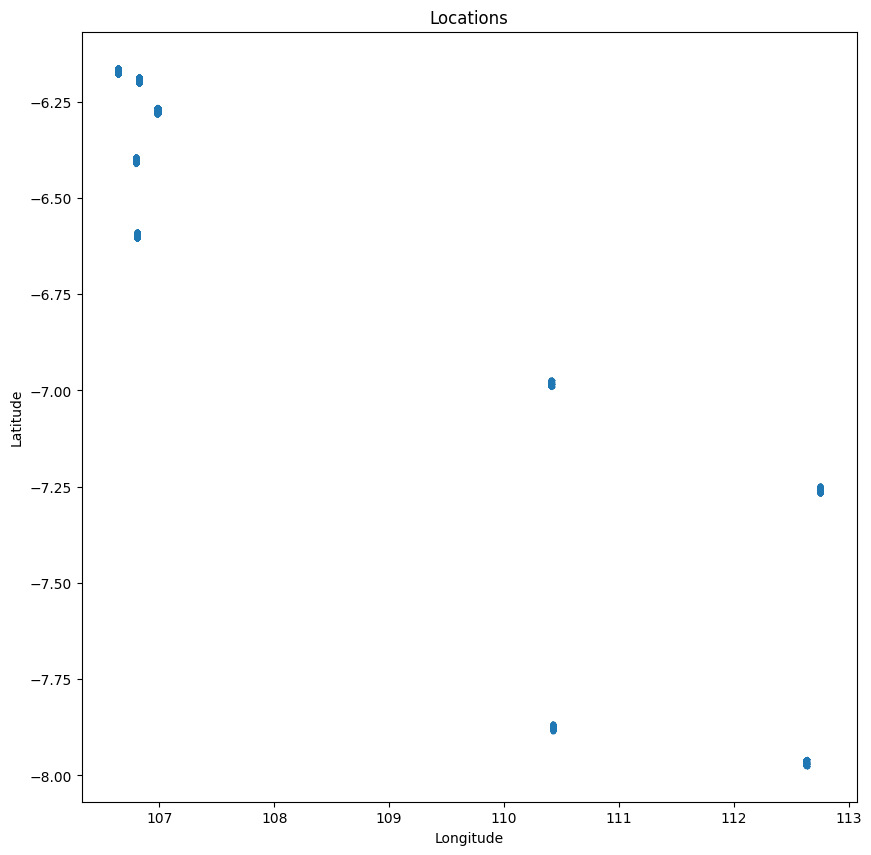

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(df["longitude"], df["latitude"], alpha=0.1, s=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Locations")
plt.show()

In [14]:
# Cluster geo_location into 9 and Find Nearest City

# Cluster geo_location and find the centroids
coords = df[["latitude", "longitude"]]

kmeans = KMeans(n_clusters=9, random_state=42)
df["cluster"] = kmeans.fit_predict(coords)

cluster_centers = df.groupby("cluster")[["latitude", "longitude"]].mean()
print(cluster_centers)

         latitude   longitude
cluster                      
0       -6.402802  106.794560
1       -7.966712  112.632584
2       -7.875552  110.426094
3       -6.981754  110.412347
4       -7.257489  112.751708
5       -6.194610  106.822891
6       -6.170428  106.640767
7       -6.597169  106.805755
8       -6.273463  106.982998


In [15]:
# Convert centroids to city
nearest_city_map = {
    0: "Depok",
    1: "Malang",
    2: "Yogyakarta",
    3: "Semarang",
    4: "Surabaya",
    5: "Jakarta",
    6: "Tangerang",
    7: "Bogor",
    8: "Bekasi"
}

df["nearest_major_city"] = df["cluster"].map(nearest_city_map)

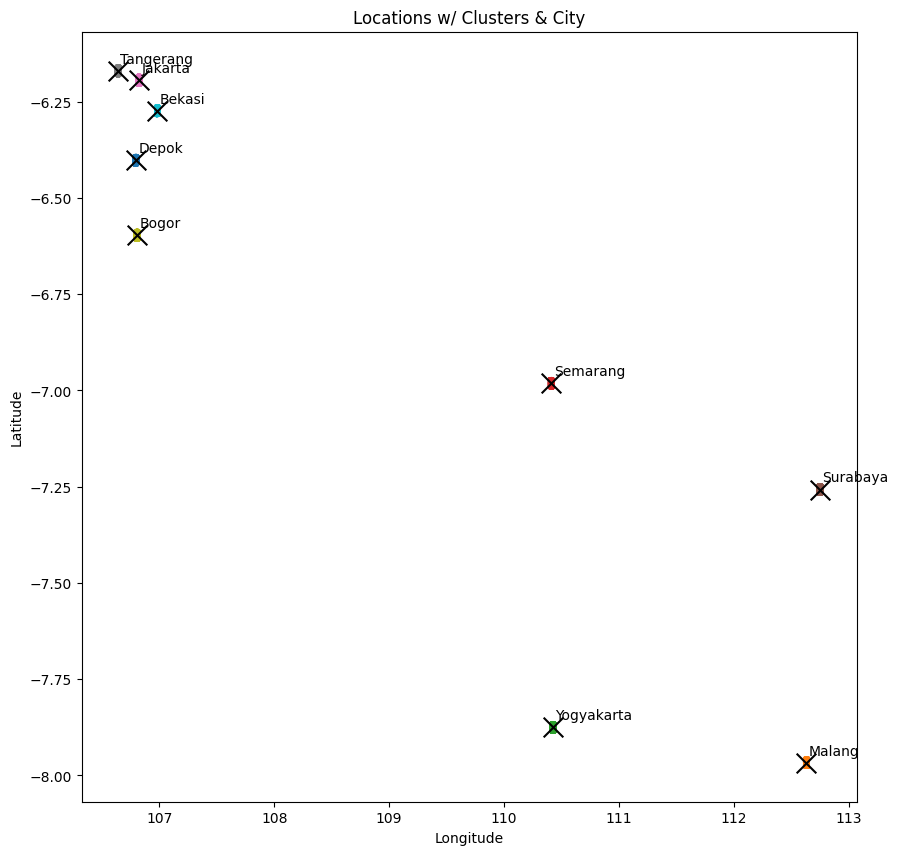

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(df["longitude"], df["latitude"], c=df["cluster"], s=5, cmap="tab10")
plt.scatter(cluster_centers["longitude"], cluster_centers["latitude"],
            s=200, c="black", marker="x")

for cluster_id, row in cluster_centers.iterrows():
    city = nearest_city_map[cluster_id]
    plt.text(
        row["longitude"] + 0.02,
        row["latitude"] + 0.02,
        city,
        fontsize=10,
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Locations w/ Clusters & City")
plt.show()


### Data Standarization

In [17]:
# Standardize Categorical Columns & Map Boolean-Like Flags

# Columns to strip/normalize text casing
cols_to_clean = [
    "transaction_id",
    "geo_location",
    "date",
]

for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()


# Map yes/no to 0/1 for certain flags
yes_no_map = {"yes": 1, "no": 0}

for col in ["loyalty_program", "discount_applied", "transaction_notes", "is_refunded", "is_weekend"]:
    df[col] = df[col].map(yes_no_map)
        

# Map completed/failed to 0/1 for transaction_status
completed_failed_map = {"completed": 1, "failed": 0}
df["transaction_status"] = df["transaction_status"].map(completed_failed_map)
        

# Convert columns to categorical dtype
categorical_to_convert = [
    "user_id",
    "merchant_id",
    "merchant_name",
    "merchant_category_id",
    "payment_method",
    "user_agent",
    "loyalty_program",
    "discount_applied",
    "transaction_notes",
    "merchant_rating",
    "transaction_status",
    "is_refunded",
    "day_of_week",
    "is_weekend",
    "month",
    "week_of_year",
    "cluster",
    "nearest_major_city",
]

for col in categorical_to_convert:
    if col in df.columns:
        df[col] = df[col].astype("category")

### Data Checking

In [18]:
# print(df)
# display(df)

In [19]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278932 entries, 0 to 278931
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   transaction_id        278932 non-null  object        
 1   user_id               278932 non-null  category      
 2   transaction_amount    278932 non-null  float64       
 3   transaction_date      278932 non-null  datetime64[ns]
 4   merchant_id           278932 non-null  category      
 5   merchant_name         278932 non-null  category      
 6   merchant_category_id  278932 non-null  category      
 7   geo_location          278932 non-null  object        
 8   payment_method        278932 non-null  category      
 9   user_agent            278932 non-null  category      
 10  loyalty_program       278932 non-null  category      
 11  discount_applied      278932 non-null  category      
 12  promo_amount          278932 non-null  float64       
 13 

None

In [20]:
# print(df.isnull().sum())
display(df.isnull().sum())

transaction_id          0
user_id                 0
transaction_amount      0
transaction_date        0
merchant_id             0
merchant_name           0
merchant_category_id    0
geo_location            0
payment_method          0
user_agent              0
loyalty_program         0
discount_applied        0
promo_amount            0
transaction_notes       0
merchant_rating         0
transaction_status      0
is_refunded             0
date                    0
day_of_week             0
is_weekend              0
month                   0
week_of_year            0
latitude                0
longitude               0
cluster                 0
nearest_major_city      0
dtype: int64

### Data Description

In [21]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric Columns:" , numeric_cols)
# print(df[numeric_cols].describe().T)
# display(df[numeric_cols].describe().T)

Numeric Columns: ['transaction_amount', 'promo_amount', 'latitude', 'longitude']


In [22]:
categorical_cols = df.select_dtypes(include=["category"]).columns.tolist()

print("Categorical Columns:", categorical_cols)
for col in categorical_cols:
    pass
    # print(df[col].value_counts())
    # display(df[col].value_counts())

Categorical Columns: ['user_id', 'merchant_id', 'merchant_name', 'merchant_category_id', 'payment_method', 'user_agent', 'loyalty_program', 'discount_applied', 'transaction_notes', 'merchant_rating', 'transaction_status', 'is_refunded', 'day_of_week', 'is_weekend', 'month', 'week_of_year', 'cluster', 'nearest_major_city']


### Data Visualization

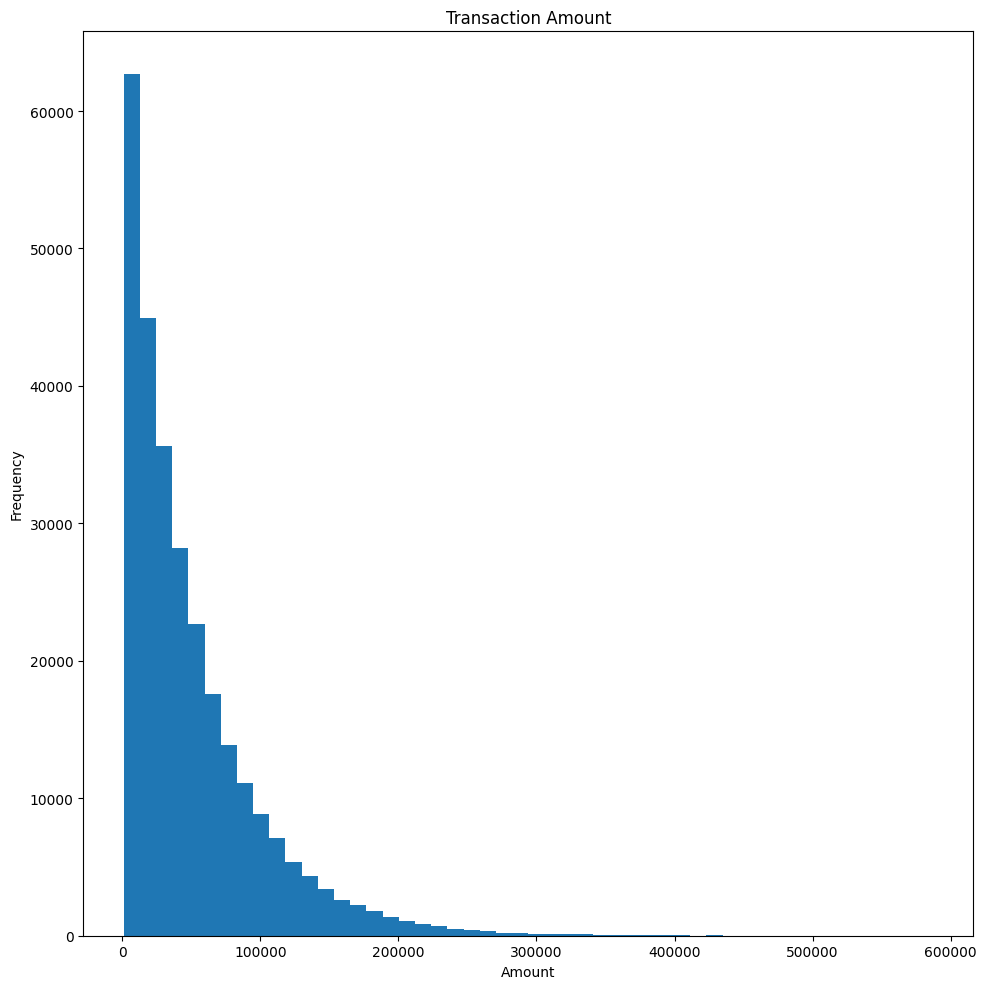

In [23]:
# transaction_amount

plt.figure(figsize=(10, 10))
plt.hist(df["transaction_amount"], bins=50)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title("Transaction Amount")
plt.tight_layout()
plt.show()

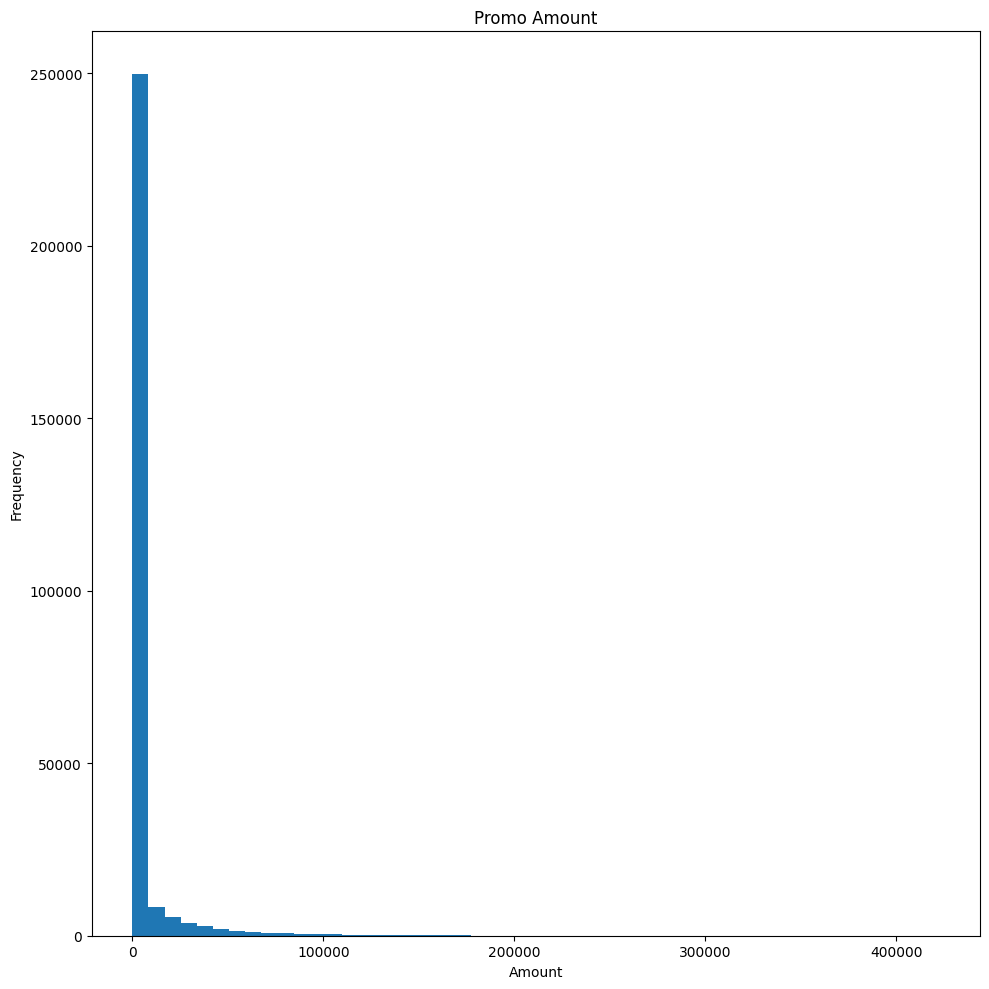

In [24]:
# promo_amount

plt.figure(figsize=(10, 10))
plt.hist(df["promo_amount"], bins=50)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title("Promo Amount")
plt.tight_layout()
plt.show()

### Data Exporting

In [25]:
# df.to_csv('./data/transactions_ida.csv', index=False)
df.to_parquet("./data/transactions_ida.parquet", index=False)

In [26]:
%reset -f

# Exploratory Data Analysis (EDA)

## Feature Engineering: User-Level Features

In [27]:
%reset -f

In [28]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Data Importing

In [29]:
# df = pd.read_csv('./data/transactions_ida.csv')
df = pd.read_parquet('./data/transactions_ida.parquet')

In [30]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278932 entries, 0 to 278931
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   transaction_id        278932 non-null  object        
 1   user_id               278932 non-null  category      
 2   transaction_amount    278932 non-null  float64       
 3   transaction_date      278932 non-null  datetime64[ns]
 4   merchant_id           278932 non-null  category      
 5   merchant_name         278932 non-null  category      
 6   merchant_category_id  278932 non-null  int64         
 7   geo_location          278932 non-null  object        
 8   payment_method        278932 non-null  category      
 9   user_agent            278932 non-null  category      
 10  loyalty_program       278932 non-null  int64         
 11  discount_applied      278932 non-null  int64         
 12  promo_amount          278932 non-null  float64       
 13 

None

### Data Grouping

In [31]:
# Group by user_id

user_group = df.groupby("user_id")

# Calculate number of transactions per user
user_base = user_group["transaction_id"].size().to_frame("n_transactions")

print("Number of Users:", user_base.shape[0])
print(user_base)

Number of Users: 24321
         n_transactions
user_id                
U00001               11
U00002               10
U00003               11
U00004                9
U00005               10
...                 ...
U24317               15
U24318                9
U24319               11
U24320               16
U24321                9

[24321 rows x 1 columns]


### Feature Creation: Spend / Volume + Completion / Refund

In [32]:
# Transaction Spend / Volume

user_spend = user_group["transaction_amount"].agg(
    total_spend="sum",
    avg_transaction_amount="mean",
    median_transaction_amount="median",
    std_transaction_amount="std",
    max_transaction_amount="max",
    min_transaction_amount="min",
)

# Coefficient of variation (handle NaNs / inf)
user_spend["cv_transaction_amount"] = (
    user_spend["std_transaction_amount"] / user_spend["avg_transaction_amount"]
)
user_spend["cv_transaction_amount"] = user_spend["cv_transaction_amount"].replace(
    [np.inf, -np.inf], np.nan
)
user_spend["cv_transaction_amount"] = user_spend["cv_transaction_amount"].fillna(0)

# Log-transformed spend
# user_spend["log_total_spend"] = np.log1p(user_spend["total_spend"])
# user_spend["log_avg_transaction_amount"] = np.log1p(user_spend["avg_transaction_amount"])


In [33]:
print("User-Level Spend / Volume:")
display(user_spend.head())

User-Level Spend / Volume:


,total_spend,avg_transaction_amount,median_transaction_amount,std_transaction_amount,max_transaction_amount,min_transaction_amount,cv_transaction_amount
user_id,,,,,,,
U00001,514600.0,46781.818182,33800.0,40790.509146,156600.0,14300.0,0.871931
U00002,364500.0,36450.000000,19650.0,34786.946786,105100.0,2200.0,0.954374
U00003,1007900.0,91627.272727,83700.0,75100.214259,230000.0,1700.0,0.819627
U00004,430800.0,47866.666667,22500.0,53745.162573,134400.0,1100.0,1.122810
U00005,795200.0,79520.000000,43550.0,105402.274907,349300.0,8400.0,1.325481


In [34]:
# Transaction Completion / Refund

# transaction_status and is_refunded are categorical with values {0,1}
df["transaction_status_num"] = df["transaction_status"].astype(int)
df["is_refunded_num"] = df["is_refunded"].astype(int)

user_status = user_group["transaction_status_num"].agg(
    n_completed="sum",
    completion_rate="mean"  # proportion of completed transactions
)

user_refund = user_group["is_refunded_num"].agg(
    n_refunded="sum",
    refund_rate="mean"  # proportion of refunded transactions
)

In [35]:
print("User-Level Completion:")
display(user_status.head())

User-Level Completion:


,n_completed,completion_rate
user_id,,
U00001,11,1.0
U00002,10,1.0
U00003,11,1.0
U00004,9,1.0
U00005,9,0.9


In [36]:
print("User-Level Refund:")
display(user_refund.head())

User-Level Refund:


,n_refunded,refund_rate
user_id,,
U00001,0,0.0
U00002,1,0.1
U00003,0,0.0
U00004,0,0.0
U00005,1,0.1


### Feature Creation: Temporal

In [37]:
# Transaction Timeline + Active Day + Recency

user_temporal = user_group["transaction_date"].agg(
    first_txn_date="min",
    last_txn_date="max",
)

# Activity span in days (inclusive)
user_temporal["activity_span_days"] = (
    user_temporal["last_txn_date"] - user_temporal["first_txn_date"]
).dt.days + 1

# Number of unique active days (dates)
user_active_days = user_group["date"].nunique().to_frame("n_active_days")
user_temporal = user_temporal.join(user_active_days)

# Average transactions per active day
user_temporal["avg_txn_per_active_day"] = (
    user_base["n_transactions"] / user_temporal["n_active_days"]
)

# Recency: days since last transaction relative to max date in dataset
max_date = df["transaction_date"].max()
user_temporal["recency_days"] = (max_date - user_temporal["last_txn_date"]).dt.days

In [38]:
print("User-Level Timeline + Active Day + Recency:")
display(user_temporal.head())

User-Level Timeline + Active Day + Recency:


,first_txn_date,last_txn_date,activity_span_days,n_active_days,avg_txn_per_active_day,recency_days
user_id,,,,,,
U00001,2024-03-07,2024-05-12,67,9,1.222222,19
U00002,2024-03-07,2024-04-20,45,9,1.111111,41
U00003,2024-03-13,2024-05-21,70,11,1.000000,10
U00004,2024-03-13,2024-05-12,61,9,1.000000,19
U00005,2024-03-07,2024-04-28,53,10,1.000000,33


In [39]:
# Transaction Weekend vs Weekday Behavior

df["is_weekend_num"] = df["is_weekend"].astype(int)

user_weekend = user_group["is_weekend_num"].mean().to_frame("weekend_txn_fraction")
user_weekend["weekday_txn_fraction"] = 1 - user_weekend["weekend_txn_fraction"]

In [40]:
print("User-Level Weekend vs Weekday Behavior:")
display(user_weekend.head())

User-Level Weekend vs Weekday Behavior:


,weekend_txn_fraction,weekday_txn_fraction
user_id,,
U00001,0.272727,0.727273
U00002,0.400000,0.600000
U00003,0.272727,0.727273
U00004,0.666667,0.333333
U00005,0.400000,0.600000


In [41]:
# Transaction Day-of-Week Distribution

user_dow = pd.crosstab(df["user_id"], df["day_of_week"], normalize="index")
user_dow.columns = [f"dow_{int(col)}_share" for col in user_dow.columns]

In [42]:
print("User-Level Day-of-Week Distribution:")
display(user_dow.head())

User-Level Day-of-Week Distribution:


,dow_0_share,dow_1_share,dow_2_share,dow_3_share,dow_4_share,dow_5_share,dow_6_share
user_id,,,,,,,
U00001,0.090909,0.272727,0.272727,0.090909,0.000000,0.090909,0.181818
U00002,0.000000,0.000000,0.200000,0.300000,0.100000,0.300000,0.100000
U00003,0.272727,0.090909,0.181818,0.090909,0.090909,0.090909,0.181818
U00004,0.111111,0.000000,0.111111,0.111111,0.000000,0.333333,0.333333
U00005,0.200000,0.100000,0.200000,0.100000,0.000000,0.100000,0.300000


In [43]:
# Transaction Month-of-Year Distribution

user_month = pd.crosstab(df["user_id"], df["month"], normalize="index")
user_month.columns = [f"month_{int(col)}_share" for col in user_month.columns]

In [44]:
print("User-Level Month-of-Year Distribution:")
display(user_month.head())

User-Level Month-of-Year Distribution:


,month_3_share,month_4_share,month_5_share
user_id,,,
U00001,0.181818,0.727273,0.090909
U00002,0.300000,0.700000,0.000000
U00003,0.181818,0.454545,0.363636
U00004,0.333333,0.444444,0.222222
U00005,0.600000,0.400000,0.000000


### Feature Creation: Merchant

In [45]:
# Transaction Category & Merchant Diversity

user_cat_basic = pd.DataFrame(index=user_base.index)
user_cat_basic["n_distinct_categories"] = user_group["merchant_category_id"].nunique()
user_cat_basic["n_distinct_merchants"] = user_group["merchant_id"].nunique()

In [46]:
print("User-Level Category & Merchant Diversity:")
display(user_cat_basic.head())

User-Level Category & Merchant Diversity:


,n_distinct_categories,n_distinct_merchants
user_id,,
U00001,9,11
U00002,5,10
U00003,7,11
U00004,7,9
U00005,9,10


In [47]:
# Transaction Category Entropy

def compute_entropy(counts):
    counts = np.asarray(counts, dtype=float)
    total = counts.sum()
    if total == 0:
        return 0.0
    probs = counts / total
    return -np.sum(probs * np.log2(probs + 1e-12))

cat_counts = (
    df.groupby(["user_id", "merchant_category_id"])
        .size()
        .to_frame("count")
        .reset_index()
)

user_category_entropy = (
    cat_counts.groupby("user_id")["count"]
    .apply(lambda x: compute_entropy(x.values))
    .to_frame("category_entropy")
)

In [48]:
print("User-Level Category Entropy:")
display(user_category_entropy.head())

User-Level Category Entropy:


,category_entropy
user_id,
U00001,3.095795
U00002,2.246439
U00003,2.594907
U00004,2.641604
U00005,3.121928


In [49]:
# Transaction Merchant Entropy

merch_counts = (
    df.groupby(["user_id", "merchant_id"])
        .size()
        .to_frame("count")
        .reset_index()
)

user_merchant_entropy = (
    merch_counts.groupby("user_id")["count"]
    .apply(lambda x: compute_entropy(x.values))
    .to_frame("merchant_entropy")
)

In [50]:
print("User-Level Merchant Entropy:")
display(user_merchant_entropy.head())

User-Level Merchant Entropy:


,merchant_entropy
user_id,
U00001,3.459432
U00002,3.321928
U00003,3.459432
U00004,3.169925
U00005,3.321928


In [ ]:
# Transaction Top Merchant Spend Share

user_merchant_spend = (
    df.groupby(["user_id", "merchant_id"])["transaction_amount"]
        .sum()
        .reset_index()
)

# For each user, find the merchant with highest total spend
idx = user_merchant_spend.groupby("user_id")["transaction_amount"].idxmax()
top_merchant = user_merchant_spend.loc[idx].set_index("user_id")

# Share of spend at top merchant
top_merchant["top_merchant_spend_share"] = (
    top_merchant["transaction_amount"] / user_spend["total_spend"]
)

user_top_merchant_share = top_merchant[["top_merchant_spend_share"]]

In [ ]:
print("User-Level Top Merchant Spend Share:")
display(user_top_merchant_share.head())

User-Level Top Merchant Spend Share:


,top_merchant_spend_share
user_id,
U00001,0.304314
U00002,0.288340
U00003,0.228197
U00004,0.311978
U00005,0.439261


In [ ]:
# Transaction Category Count Share for Top 10 MCCs
# Transaction Category Spend Share for Top 10 MCCs

# Identify top 10 merchant_category_id by overall transaction count
top_mcc_ids = df["merchant_category_id"].value_counts().head(10).index

df_top_mcc = df[df["merchant_category_id"].isin(top_mcc_ids)].copy()

# Count share: fraction of transactions in each of top MCCs
user_cat_count_share = pd.crosstab(
    df_top_mcc["user_id"],
    df_top_mcc["merchant_category_id"],
    normalize="index",
)
user_cat_count_share.columns = [
    f"cat_{int(col)}_count_share" for col in user_cat_count_share.columns
]

# Spend share: fraction of total spend in each of top MCCs
user_cat_spend = df_top_mcc.pivot_table(
    index="user_id",
    columns="merchant_category_id",
    values="transaction_amount",
    aggfunc="sum",
)

user_cat_spend = user_cat_spend.div(user_spend["total_spend"], axis=0)
user_cat_spend = user_cat_spend.fillna(0)
user_cat_spend.columns = [
    f"cat_{int(col)}_spend_share" for col in user_cat_spend.columns
]


In [ ]:
print("User-Level Category Count Share for Top 10 MCCs:")
display(user_cat_count_share.head())

print("User-Level Category Spend Share for Top 10 MCCs:")
display(user_cat_spend.head())

User-Level Category Count Share for Top 10 MCCs:


,cat_5251_count_share,cat_5411_count_share,cat_5412_count_share,cat_5541_count_share,cat_5732_count_share,cat_5812_count_share,cat_5814_count_share,cat_5912_count_share,cat_5942_count_share,cat_5999_count_share
user_id,,,,,,,,,,
U00001,0.000000,0.000000,0.000000,0.142857,0.142857,0.142857,0.142857,0.142857,0.000000,0.285714
U00002,0.000000,0.125000,0.000000,0.250000,0.000000,0.375000,0.250000,0.000000,0.000000,0.000000
U00003,0.000000,0.111111,0.000000,0.111111,0.000000,0.333333,0.333333,0.111111,0.000000,0.000000
U00004,0.166667,0.000000,0.166667,0.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000
U00005,0.000000,0.000000,0.142857,0.000000,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


User-Level Category Spend Share for Top 10 MCCs:


,cat_5251_spend_share,cat_5411_spend_share,cat_5412_spend_share,cat_5541_spend_share,cat_5732_spend_share,cat_5812_spend_share,cat_5814_spend_share,cat_5912_spend_share,cat_5942_spend_share,cat_5999_spend_share
user_id,,,,,,,,,,
U00001,0.000000,0.000000,0.000000,0.041586,0.116012,0.114846,0.304314,0.065682,0.000000,0.071123
U00002,0.000000,0.035391,0.000000,0.058162,0.000000,0.221125,0.315226,0.000000,0.000000,0.000000
U00003,0.000000,0.053279,0.000000,0.213216,0.000000,0.177597,0.312928,0.093462,0.000000,0.000000
U00004,0.184076,0.000000,0.307567,0.000000,0.000000,0.057799,0.052228,0.000000,0.000000,0.000000
U00005,0.000000,0.000000,0.025025,0.000000,0.010563,0.015342,0.074824,0.041122,0.439261,0.068410


### Feature Creation: Location

In [ ]:
# Transaction Distinct Locations

# Number of distinct lat/lon pairs per user
unique_locs = df[["user_id", "latitude", "longitude"]].drop_duplicates()

user_geo_basic = pd.DataFrame(index=user_base.index)
user_geo_basic["n_distinct_locations"] = (
    unique_locs.groupby("user_id").size().reindex(user_base.index, fill_value=0)
)

In [ ]:
print("User-Level Distinct Locations:")
display(user_geo_basic.head())

User-Level Distinct Locations:


,n_distinct_locations
user_id,
U00001,11
U00002,10
U00003,11
U00004,9
U00005,10


In [ ]:
# Transaction Geo Centroids

user_geo_centroid = df.groupby("user_id")[["latitude", "longitude"]].mean()
user_geo_centroid = user_geo_centroid.rename(
    columns={"latitude": "centroid_lat", "longitude": "centroid_lon"}
)

In [ ]:
print("User-Level Geo Centroids:")
display(user_geo_centroid.head())

User-Level Geo Centroids:


,centroid_lat,centroid_lon
user_id,,
U00001,-6.290074,106.814729
U00002,-7.538468,112.702112
U00003,-6.235291,106.844590
U00004,-6.317355,106.811432
U00005,-6.270892,106.781261


In [ ]:
# Transaction Geo Dispersion

def haversine_array(lat1, lon1, lat2, lon2):
    """
    Vectorized haversine distance for arrays of lat/lon in degrees.
    Returns distance in kilometers.
    """
    R = 6371.0  # Earth radius in km
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df_geo = df[["user_id", "latitude", "longitude"]].merge(
    user_geo_centroid,
    left_on="user_id",
    right_index=True,
    how="left",
)

df_geo["dist_to_centroid_km"] = haversine_array(
    df_geo["latitude"],
    df_geo["longitude"],
    df_geo["centroid_lat"],
    df_geo["centroid_lon"],
)

user_geo_dispersion = (
    df_geo.groupby("user_id")["dist_to_centroid_km"]
    .mean()
    .to_frame("avg_distance_from_centroid_km")
)

In [ ]:
print("User-Level Geo Dispersion:")
display(user_geo_dispersion.head())

User-Level Geo Dispersion:


,avg_distance_from_centroid_km
user_id,
U00001,15.023738
U00002,38.458816
U00003,13.739299
U00004,20.997330
U00005,15.286741


In [ ]:
# Transaction City Behaviour

# Number of distinct nearest_major_city per user
user_city = df.groupby("user_id")["nearest_major_city"].nunique().to_frame("n_cities")

# Primary city: most frequent nearest_major_city
user_primary_city = (
    df.groupby("user_id")["nearest_major_city"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_frame("primary_city")
)

# City share features: fraction of transactions in each city
user_city_share = pd.crosstab(
    df["user_id"], df["nearest_major_city"], normalize="index"
)
user_city_share.columns = [f"city_{str(col)}_share" for col in user_city_share.columns]

In [ ]:
print("User-Level City Behaviour:")
display(user_city.head())
display(user_primary_city.head())
display(user_city_share.head())

User-Level City Behaviour:


,n_cities
user_id,
U00001,3
U00002,2
U00003,4
U00004,5
U00005,4


,primary_city
user_id,
U00001,Jakarta
U00002,Surabaya
U00003,Bekasi
U00004,Bekasi
U00005,Jakarta


,city_Bekasi_share,city_Bogor_share,city_Depok_share,city_Jakarta_share,city_Malang_share,city_Semarang_share,city_Surabaya_share,city_Tangerang_share,city_Yogyakarta_share
user_id,,,,,,,,,
U00001,0.000000,0.181818,0.090909,0.727273,0.0,0.0,0.0,0.000000,0.0
U00002,0.000000,0.000000,0.000000,0.000000,0.4,0.0,0.6,0.000000,0.0
U00003,0.363636,0.000000,0.090909,0.363636,0.0,0.0,0.0,0.181818,0.0
U00004,0.222222,0.222222,0.111111,0.222222,0.0,0.0,0.0,0.222222,0.0
U00005,0.000000,0.100000,0.200000,0.500000,0.0,0.0,0.0,0.200000,0.0


### Feature Creation: Payment + Device

In [ ]:
# Transaction Payment

# Indicator for credit card transactions
df["is_credit_card"] = (df["payment_method"] == "credit_card").astype(int)

user_payment = user_group["is_credit_card"].agg(
    n_credit_card="sum",
    credit_card_txn_fraction="mean",
)

# Number of balance (non-credit) transactions and their fraction
user_payment["n_balance"] = (
    user_base["n_transactions"] - user_payment["n_credit_card"]
)
user_payment["balance_txn_fraction"] = (
    user_payment["n_balance"] / user_base["n_transactions"]
)

In [ ]:
print("User-Level Payment:")
display(user_payment.head())

User-Level Payment:


,n_credit_card,credit_card_txn_fraction,n_balance,balance_txn_fraction
user_id,,,,
U00001,2,0.181818,9,0.818182
U00002,3,0.300000,7,0.700000
U00003,1,0.090909,10,0.909091
U00004,0,0.000000,9,1.000000
U00005,1,0.100000,9,0.900000


In [ ]:
# Transaction Device

def get_device_family(ua):
    ua = str(ua).lower()
    if "android" in ua:
        return "android"
    if "iphone" in ua:
        return "iphone"
    if "ipad" in ua:
        return "ipad"
    return "other"

df["device_family"] = df["user_agent"].astype(str).apply(get_device_family)
df["device_family"] = df["device_family"].astype("category")

# Number of distinct device families per user
# user_device_counts = (
#     df.groupby("user_id")["device_family"]
#     .nunique()
#     .to_frame("n_device_families")
# )

# Primary device family (mode)
user_primary_device = (
    df.groupby("user_id")["device_family"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_frame("primary_device_family")
)

# Device family share features: fraction of transactions from each device type
# user_device_share = pd.crosstab(
#     df["user_id"], df["device_family"], normalize="index"
# )
# user_device_share.columns = [
#     f"device_{str(col)}_share" for col in user_device_share.columns
# ]

In [ ]:
print("User-Level Device:")
# display(user_device_counts.head())
display(user_primary_device.head())
# display(user_device_share.head())

User-Level Device:


,primary_device_family
user_id,
U00001,android
U00002,android
U00003,android
U00004,android
U00005,android


### Feature Creation: Loyalty Program + Discount + Promo

In [ ]:
# Transaction Loyalty Program + Discount

df["loyalty_program_num"] = df["loyalty_program"].astype(int)
df["discount_applied_num"] = df["discount_applied"].astype(int)
df["transaction_notes_num"] = df["transaction_notes"].astype(int)

# Loyalty metrics
user_loyalty = user_group["loyalty_program_num"].agg(
    loyalty_txn_count="sum",
    loyalty_txn_fraction="mean",
)
user_loyalty["is_loyalty_member"] = (
    user_loyalty["loyalty_txn_count"] > 0
).astype(int)

# Discount metrics
user_discount = user_group["discount_applied_num"].agg(
    discount_txn_count="sum",
    discount_txn_fraction="mean",
)

# # Notes presence: fraction of transactions with notes
# user_notes = user_group["transaction_notes_num"].mean().to_frame(
#     "notes_txn_fraction"
# )

In [ ]:
print("User-Level Loyalty Program:")
display(user_loyalty.head())

print("User-Level Discount:")
display(user_discount.head())

User-Level Loyalty Program:


,loyalty_txn_count,loyalty_txn_fraction,is_loyalty_member
user_id,,,
U00001,0,0.0,0
U00002,0,0.0,0
U00003,11,1.0,1
U00004,0,0.0,0
U00005,0,0.0,0


User-Level Discount:


,discount_txn_count,discount_txn_fraction
user_id,,
U00001,2,0.181818
U00002,1,0.100000
U00003,1,0.090909
U00004,0,0.000000
U00005,0,0.000000


In [ ]:
# Transaction Promo

user_promo = user_group["promo_amount"].agg(
    total_promo_amount="sum",
    avg_promo_amount="mean",
)

# Promo to spend ratio
user_promo["promo_to_spend_ratio"] = (
    user_promo["total_promo_amount"] / user_spend["total_spend"]
).fillna(0)

In [ ]:
print("User-Level Promo:")
display(user_promo.head())

User-Level Promo:


,total_promo_amount,avg_promo_amount,promo_to_spend_ratio
user_id,,,
U00001,34400.0,3127.272727,0.066848
U00002,5600.0,560.000000,0.015364
U00003,37500.0,3409.090909,0.037206
U00004,0.0,0.000000,0.000000
U00005,0.0,0.000000,0.000000


### Feature Creation: Ratings

In [ ]:
# Transaction Ratings

df["merchant_rating_num"] = df["merchant_rating"].astype(int)

user_rating_basic = user_group["merchant_rating_num"].agg(
    avg_rating="mean",
    rating_std="std",
    min_rating="min",
    max_rating="max",
)

# Count of low ratings (<=2) and high ratings (>=4)
low_rating_mask = df["merchant_rating_num"] <= 2
high_rating_mask = df["merchant_rating_num"] >= 4

user_low_ratings = (
    df[low_rating_mask].groupby("user_id").size().to_frame("n_low_ratings")
)
user_high_ratings = (
    df[high_rating_mask].groupby("user_id").size().to_frame("n_high_ratings")
)

# Reindex to include users with 0 low/high ratings
user_low_ratings = user_low_ratings.reindex(user_base.index, fill_value=0)
user_high_ratings = user_high_ratings.reindex(user_base.index, fill_value=0)

# Combine rating features
user_rating = user_rating_basic.join(user_low_ratings, how="left").join(
    user_high_ratings, how="left"
)

In [ ]:
print("User-Level Ratings:")
display(user_rating.head())

User-Level Ratings:


,avg_rating,rating_std,min_rating,max_rating,n_low_ratings,n_high_ratings
user_id,,,,,,
U00001,3.818182,0.981650,2,5,1,7
U00002,3.900000,1.370320,1,5,2,8
U00003,4.272727,0.786245,3,5,0,9
U00004,3.444444,1.236033,1,5,2,6
U00005,3.700000,1.059350,2,5,1,5


### Feature Selection

In [ ]:
user_features = user_base.join(user_spend, how="left")

# Spend / Volume + Completion / Refund
user_features = user_features.join(user_status, how="left")
user_features = user_features.join(user_refund, how="left")

# Temporal
user_features = user_features.join(user_temporal, how="left")
user_features = user_features.join(user_weekend, how="left")
user_features = user_features.join(user_dow, how="left")
user_features = user_features.join(user_month, how="left")

# Merchant
user_features = user_features.join(user_cat_basic, how="left")
user_features = user_features.join(user_category_entropy, how="left")
user_features = user_features.join(user_merchant_entropy, how="left")
user_features = user_features.join(user_top_merchant_share, how="left")
user_features = user_features.join(user_cat_count_share, how="left")
user_features = user_features.join(user_cat_spend, how="left")

# Location
user_geo_all = user_geo_basic.join(user_geo_centroid, how="left")
user_geo_all = user_geo_all.join(user_geo_dispersion, how="left")
user_geo_all = user_geo_all.join(user_city, how="left")
user_geo_all = user_geo_all.join(user_primary_city, how="left")
user_geo_all = user_geo_all.join(user_city_share, how="left")
user_features = user_features.join(user_geo_all, how="left")

# Payment + Device
# user_device_all = user_device_counts.join(user_primary_device, how="left")
# user_device_all = user_device_all.join(user_device_share, how="left")
user_features = user_features.join(user_primary_device, how="left")

user_features = user_features.join(user_payment, how="left")

# Loyalty Program + Discount + Promo
user_features = user_features.join(user_loyalty, how="left")
user_features = user_features.join(user_discount, how="left")
# user_features = user_features.join(user_notes, how="left")
user_features = user_features.join(user_promo, how="left")

# Ratings
user_features = user_features.join(user_rating, how="left")

### Data Checking

In [ ]:
print("User-Level Features:", user_features.shape)
print(user_features.head())
# display(user_features.head())

In [ ]:
display(user_features.info())

In [ ]:
print(user_features.isnull().sum())
# display(user_features.isnull().sum())

### Data Visualization

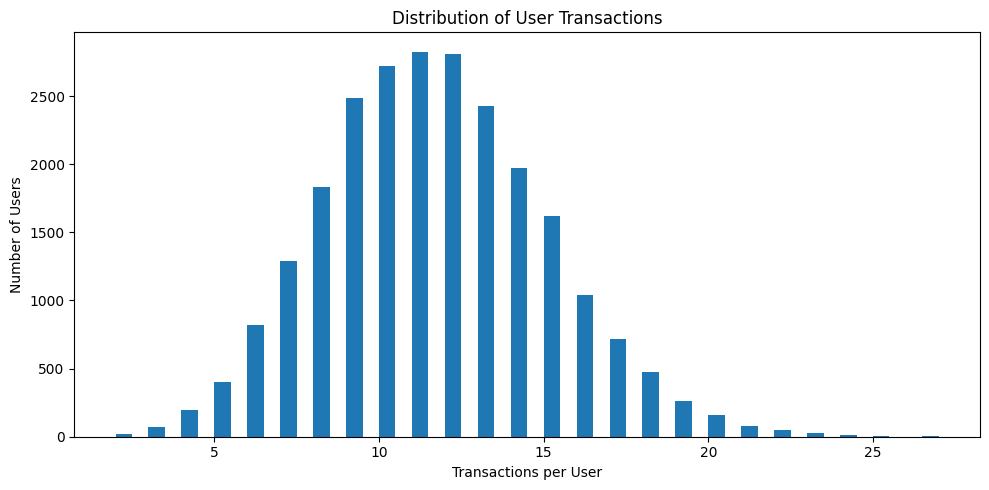

In [ ]:
# Distribution of User Transactions

plt.figure(figsize=(10, 5))
plt.hist(user_features["n_transactions"], bins=50)
plt.xlabel("Transactions per User")
plt.ylabel("Number of Users")
plt.title("Distribution of User Transactions")
plt.tight_layout()
plt.show()

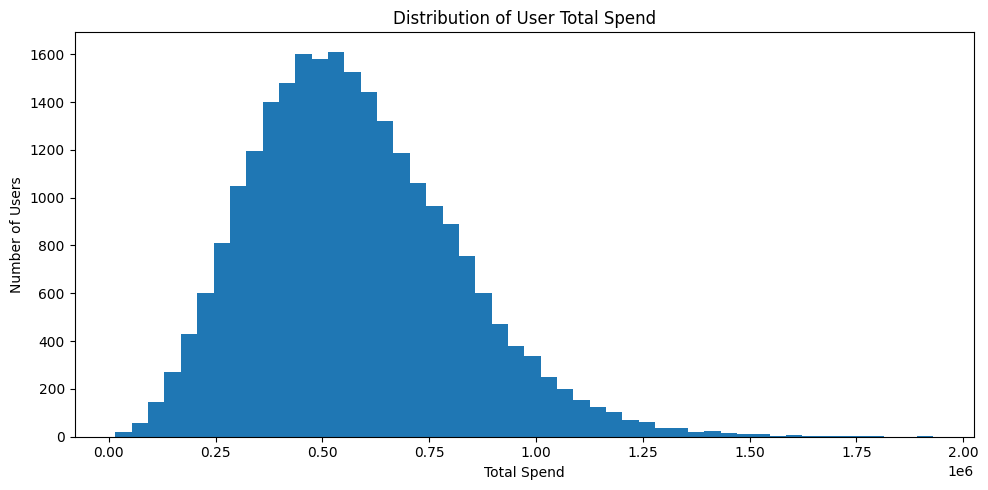

In [ ]:
# Distribution of User Total Spend

plt.figure(figsize=(10, 5))
plt.hist(user_features["total_spend"], bins=50)
plt.xlabel("Total Spend")
plt.ylabel("Number of Users")
plt.title("Distribution of User Total Spend")
plt.tight_layout()
plt.show()


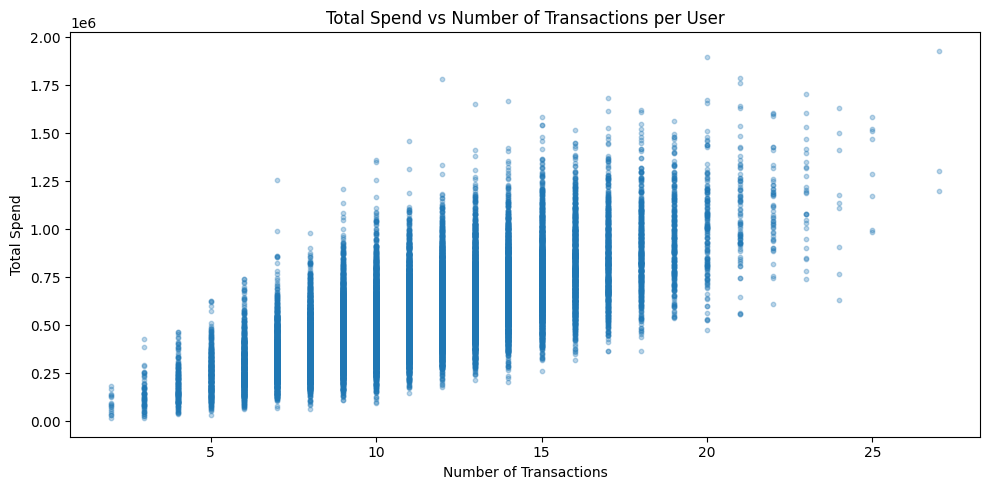

In [ ]:
# Total Spend vs Number of Transactions per User

plt.figure(figsize=(10, 5))
plt.scatter(
    user_features["n_transactions"],
    user_features["total_spend"],
    alpha=0.3,
    s=10,
)
plt.xlabel("Number of Transactions")
plt.ylabel("Total Spend")
plt.title("Total Spend vs Number of Transactions per User")
plt.tight_layout()
plt.show()

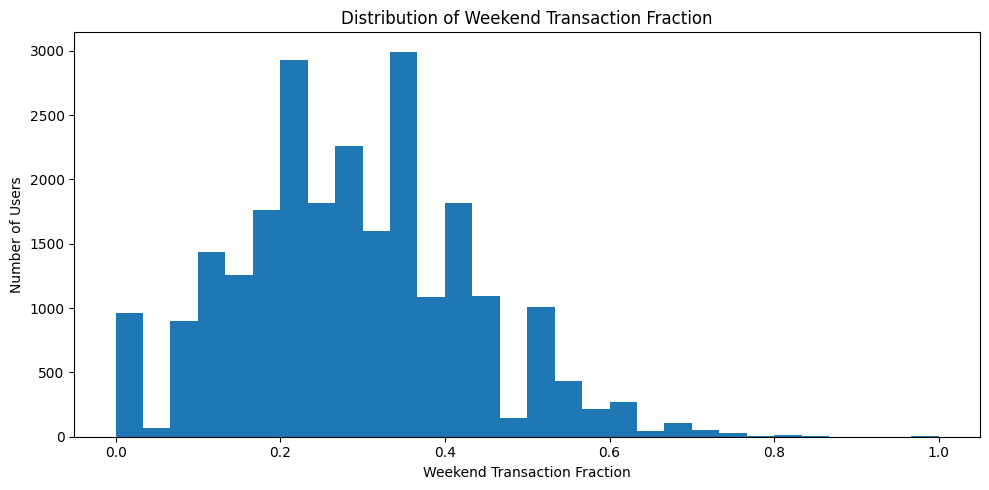

In [ ]:
# Distribution of Weekend Transaction Fraction

plt.figure(figsize=(10, 5))
plt.hist(user_features["weekend_txn_fraction"], bins=30)
plt.xlabel("Weekend Transaction Fraction")
plt.ylabel("Number of Users")
plt.title("Distribution of Weekend Transaction Fraction")
plt.tight_layout()
plt.show()

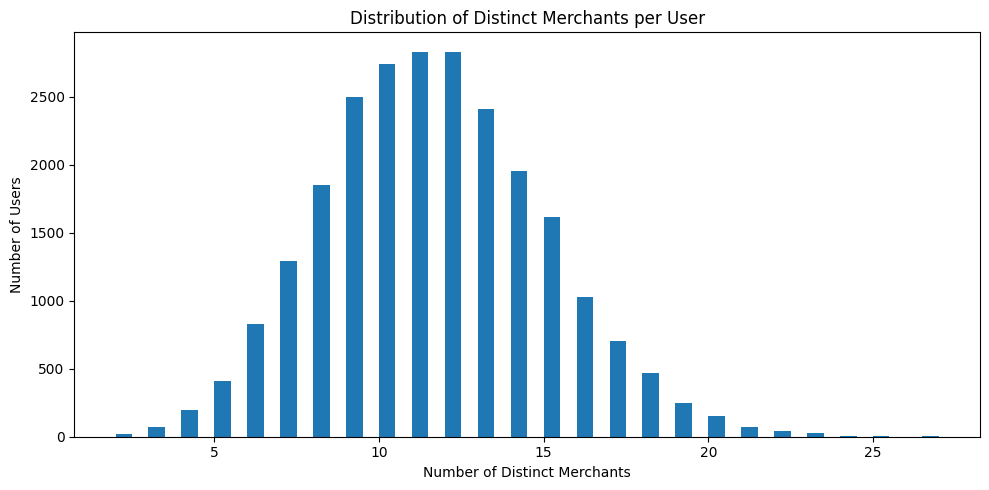

In [ ]:
# Distribution of Distinct Merchants per User

plt.figure(figsize=(10, 5))
plt.hist(user_features["n_distinct_merchants"].dropna(), bins=50)
plt.xlabel("Number of Distinct Merchants")
plt.ylabel("Number of Users")
plt.title("Distribution of Distinct Merchants per User")
plt.tight_layout()
plt.show()

### Data Exporting

In [ ]:
# user_features.to_csv('./data/transactions_eda_ulf.csv', index=False)
user_features.to_parquet("./data/transactions_eda_ulf.parquet", index=False)

In [ ]:
%reset -f

## Feature Engineering: Derived Features

In [1]:
%reset -f

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Data Importing

In [3]:
# user_features = pd.read_csv('./data/transactions_eda_ulf.csv')
user_features = pd.read_parquet('./data/transactions_eda_ulf.parquet')

In [4]:
display(user_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24321 entries, 0 to 24320
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   n_transactions                 24321 non-null  int64         
 1   total_spend                    24321 non-null  float64       
 2   avg_transaction_amount         24321 non-null  float64       
 3   median_transaction_amount      24321 non-null  float64       
 4   std_transaction_amount         24321 non-null  float64       
 5   max_transaction_amount         24321 non-null  float64       
 6   min_transaction_amount         24321 non-null  float64       
 7   cv_transaction_amount          24321 non-null  float64       
 8   n_completed                    24321 non-null  int32         
 9   completion_rate                24321 non-null  float64       
 10  n_refunded                     24321 non-null  int32         
 11  refund_rate    

None

### Data Aggregation

In [5]:
def min_max_scale(series):
    """
    Min-max scale a pandas Series to [0, 1].
    - Handles NaN and inf gracefully.
    - If constant series, returns 0.5 for all.
    """
    s = series.replace([np.inf, -np.inf], np.nan)
    # Fill NaN with mean (or 0 if all NaN)
    if s.isna().all():
        return pd.Series(0.5, index=series.index)
    s = s.fillna(s.mean())
    min_val = s.min()
    max_val = s.max()
    if max_val == min_val:
        return pd.Series(0.5, index=series.index)
    return (s - min_val) / (max_val - min_val)


def z_score(series):
    """
    Standard z-score: (x - mean) / std.
    If std is 0, returns 0 for all.
    """
    s = series.replace([np.inf, -np.inf], np.nan)
    s = s.fillna(s.mean())
    std = s.std(ddof=0)
    if std == 0 or np.isnan(std):
        return pd.Series(0.0, index=series.index)
    return (s - s.mean()) / std

In [6]:
# Category Aggregates

# Ensure missing columns default to 0 (defensive)
for col in [
    "cat_5812_spend_share", "cat_5814_spend_share",  # restaurants & bars
    "cat_5411_spend_share", "cat_5412_spend_share",  # grocery-ish
    "cat_5912_spend_share",                          # pharmacies
    "cat_5942_spend_share",                          # books/stationery
    "cat_5999_spend_share",                          # general retail
    "cat_5541_spend_share",                          # fuel/service stations
]:
    if col not in user_features.columns:
        user_features[col] = 0.0

user_features["restaurant_spend_share"] = (
    user_features["cat_5812_spend_share"] +
    user_features["cat_5814_spend_share"]
)

user_features["grocery_spend_share"] = (
    user_features["cat_5411_spend_share"] +
    user_features["cat_5412_spend_share"]
)

user_features["pharmacy_spend_share"] = user_features["cat_5912_spend_share"]

user_features["general_retail_spend_share"] = (
    user_features["cat_5999_spend_share"] +
    user_features["cat_5942_spend_share"]
)

user_features["fuel_spend_share"] = user_features["cat_5541_spend_share"]

# A "family/household" proxy: groceries + pharmacies
user_features["family_spend_share"] = (
    user_features["grocery_spend_share"] +
    user_features["pharmacy_spend_share"]
)

In [7]:
print("Category Aggregates:")
display(user_features[[
    "restaurant_spend_share",
    "grocery_spend_share",
    "pharmacy_spend_share",
    "general_retail_spend_share",
    "fuel_spend_share",
    "family_spend_share"
]].head())

Category Aggregates:


,restaurant_spend_share,grocery_spend_share,pharmacy_spend_share,general_retail_spend_share,fuel_spend_share,family_spend_share
0,0.419161,0.000000,0.065682,0.071123,0.041586,0.065682
1,0.536351,0.035391,0.000000,0.000000,0.058162,0.035391
2,0.490525,0.053279,0.093462,0.000000,0.213216,0.146741
3,0.110028,0.307567,0.000000,0.000000,0.000000,0.307567
4,0.090166,0.025025,0.041122,0.507671,0.000000,0.066147


### 1st Priority

### Feature Creation: Big Five Personality Score

#### Big Five: Openness

In [8]:
# Big Five: Openness

o_cat_entropy = min_max_scale(user_features["category_entropy"])
o_merch_entropy = min_max_scale(user_features["merchant_entropy"])
o_n_locs = min_max_scale(user_features["n_distinct_locations"])
o_geo_disp = min_max_scale(user_features["avg_distance_from_centroid_km"])
o_n_cities = min_max_scale(user_features["n_cities"])

user_features["big5_openness"] = (
    o_cat_entropy +
    o_merch_entropy +
    o_n_locs +
    o_geo_disp +
    o_n_cities
) / 5.0

In [9]:
print("Big Five – Openness:")
display(user_features[["big5_openness"]].head())

Big Five – Openness:


,big5_openness
0,0.526246
1,0.509642
2,0.544562
3,0.594647
4,0.563359


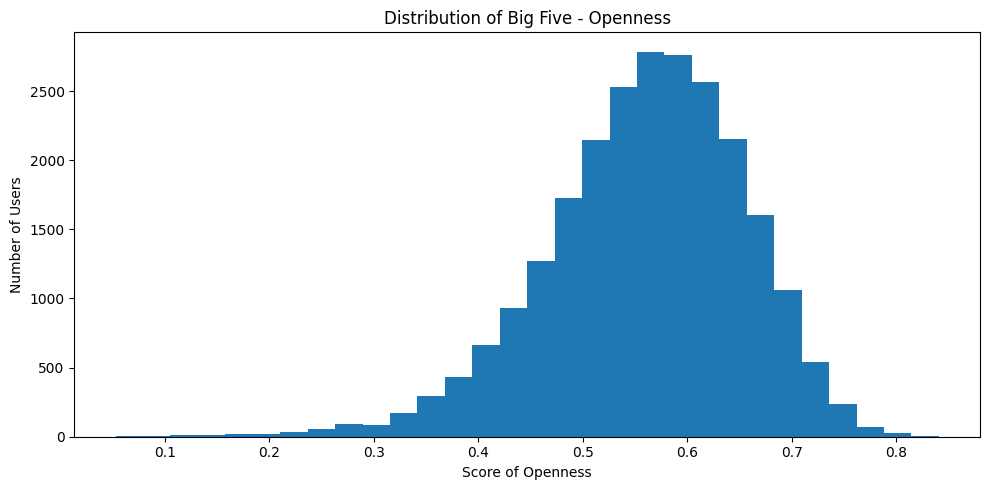

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["big5_openness"], bins=30)
plt.title("Distribution of Big Five - Openness")
plt.xlabel("Score of Openness")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

#### Big Five: Conscientiousness

In [11]:
# Big Five: Conscientiousness

c_stable_spend = 1 - min_max_scale(user_features["cv_transaction_amount"])
c_low_refund = 1 - min_max_scale(user_features["refund_rate"])
c_completion = min_max_scale(user_features["completion_rate"])
c_loyalty = min_max_scale(user_features["loyalty_txn_fraction"])

user_features["big5_conscientiousness"] = (
    c_stable_spend +
    c_low_refund +
    c_completion +
    c_loyalty
) / 4.0

In [12]:
print("Big Five – Conscientiousness:")
display(user_features[["big5_conscientiousness"]].head())

Big Five – Conscientiousness:


,big5_conscientiousness
0,0.655363
1,0.604697
2,0.911073
3,0.627977
4,0.530853


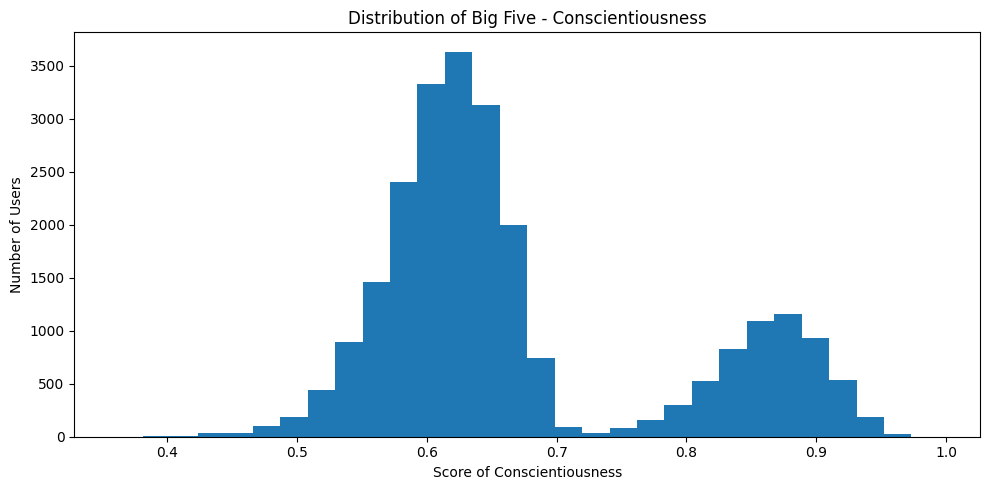

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["big5_conscientiousness"], bins=30)
plt.title("Distribution of Big Five - Conscientiousness")
plt.xlabel("Score of Conscientiousness")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

#### Big Five: Extraversion

In [14]:
# Big Five: Extraversion

e_weekend = min_max_scale(user_features["weekend_txn_fraction"])
e_restaurants = min_max_scale(user_features["restaurant_spend_share"])
e_city_diversity = min_max_scale(user_features["n_cities"])

user_features["big5_extraversion"] = (
    e_weekend +
    e_restaurants +
    e_city_diversity
) / 3.0

In [15]:
print("Big Five – Extraversion:")
display(user_features[["big5_extraversion"]].head())

Big Five – Extraversion:


,big5_extraversion
0,0.397296
1,0.395450
2,0.504417
3,0.592232
4,0.413389


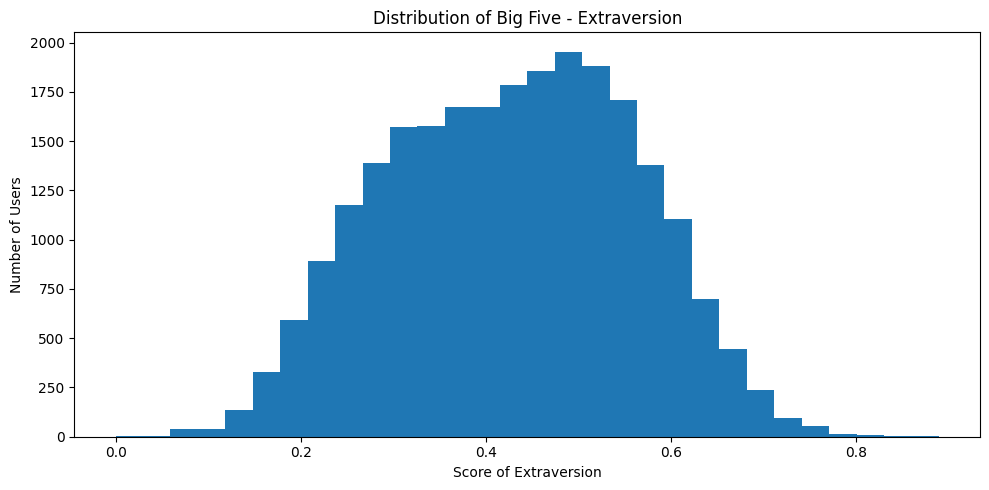

In [16]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["big5_extraversion"], bins=30)
plt.title("Distribution of Big Five - Extraversion")
plt.xlabel("Score of Extraversion")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

#### Big Five: Agreeableness

In [17]:
# Big Five: Agreeableness

low_rating_rate = user_features["n_low_ratings"] / user_features["n_transactions"]

a_high_rating = min_max_scale(user_features["avg_rating"])
a_low_low_rating_rate = 1 - min_max_scale(low_rating_rate)
a_low_refund = 1 - min_max_scale(user_features["refund_rate"])

user_features["big5_agreeableness"] = (
    a_high_rating +
    a_low_low_rating_rate +
    a_low_refund
) / 3.0

In [18]:
print("Big Five – Agreeableness:")
display(user_features[["big5_agreeableness"]].head())

Big Five – Agreeableness:


,big5_agreeableness
0,0.857143
1,0.773016
2,0.930736
3,0.777778
4,0.787302


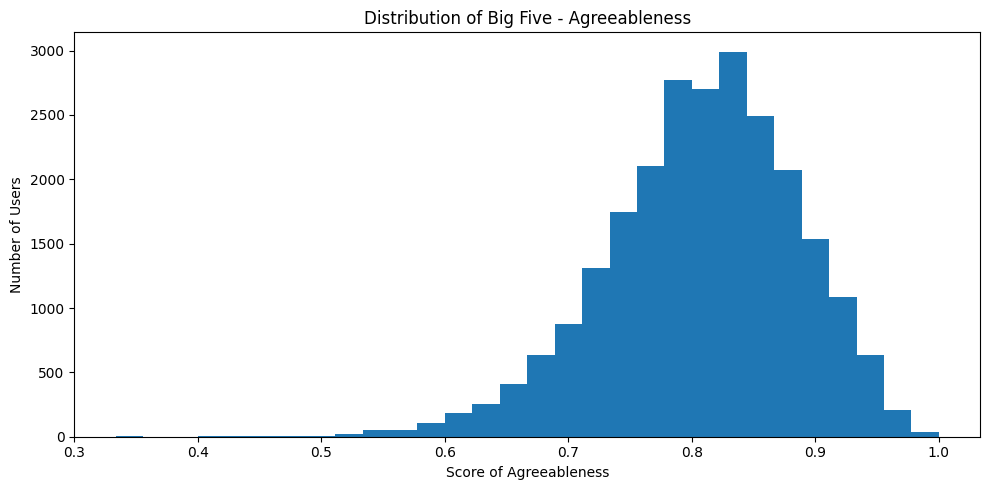

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["big5_agreeableness"], bins=30)
plt.title("Distribution of Big Five - Agreeableness")
plt.xlabel("Score of Agreeableness")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

#### Big Five: Neuroticism

In [20]:
# Big Five: Neuroticism

n_high_cv = min_max_scale(user_features["cv_transaction_amount"])
n_high_refund = min_max_scale(user_features["refund_rate"])
n_low_avg_rating = 1 - min_max_scale(user_features["avg_rating"])
n_high_low_rating_rate = min_max_scale(low_rating_rate)

user_features["big5_neuroticism"] = (
    n_high_cv +
    n_high_refund +
    n_low_avg_rating +
    n_high_low_rating_rate
) / 4.0

In [21]:
print("Big Five – Neuroticism:")
display(user_features[["big5_neuroticism"]].head())

Big Five – Neuroticism:


,big5_neuroticism
0,0.201780
1,0.273875
2,0.140875
3,0.288690
4,0.303671


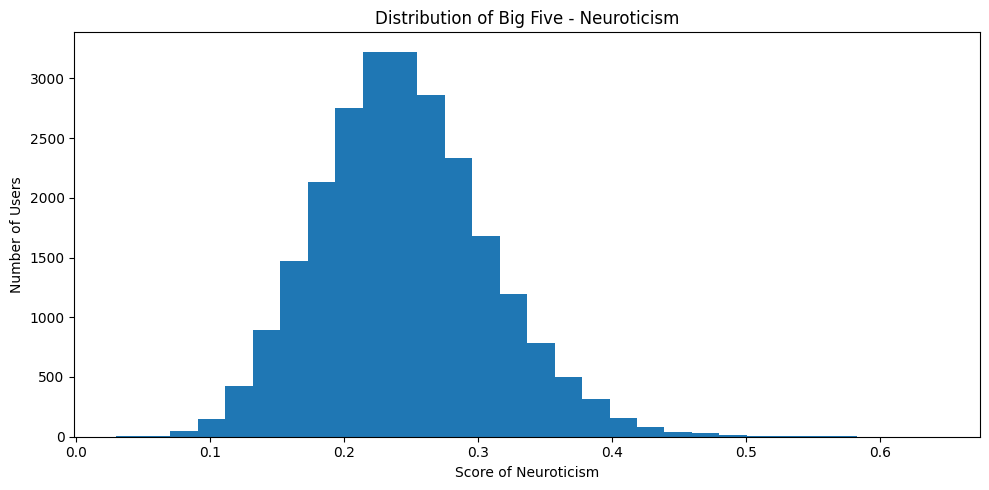

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["big5_neuroticism"], bins=30)
plt.title("Distribution of Big Five - Neuroticism")
plt.xlabel("Score of Neuroticism")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

#### Big Five

In [23]:
# Big Five

big5_features = [
    "big5_openness",
    "big5_conscientiousness",
    "big5_extraversion",
    "big5_agreeableness",
    "big5_neuroticism"
]

In [24]:
print("Big Five:")
display(user_features[big5_features].head())

Big Five:


,big5_openness,big5_conscientiousness,big5_extraversion,big5_agreeableness,big5_neuroticism
0,0.526246,0.655363,0.397296,0.857143,0.201780
1,0.509642,0.604697,0.395450,0.773016,0.273875
2,0.544562,0.911073,0.504417,0.930736,0.140875
3,0.594647,0.627977,0.592232,0.777778,0.288690
4,0.563359,0.530853,0.413389,0.787302,0.303671


#### Big Five Correlation Matrix

In [25]:
# Big Five Correlation Matrix

big5_cols = [
    "big5_openness",
    "big5_conscientiousness",
    "big5_extraversion",
    "big5_agreeableness",
    "big5_neuroticism",
]
corr = user_features[big5_cols].corr()

In [26]:
print("Big Five Correlation Matrix:")
display(corr)

Big Five Correlation Matrix:


,big5_openness,big5_conscientiousness,big5_extraversion,big5_agreeableness,big5_neuroticism
big5_openness,1.000000,-0.021292,0.347320,0.005235,0.029435
big5_conscientiousness,-0.021292,1.000000,0.000637,0.108340,-0.187829
big5_extraversion,0.347320,0.000637,1.000000,0.009458,-0.000938
big5_agreeableness,0.005235,0.108340,0.009458,1.000000,-0.916782
big5_neuroticism,0.029435,-0.187829,-0.000938,-0.916782,1.000000


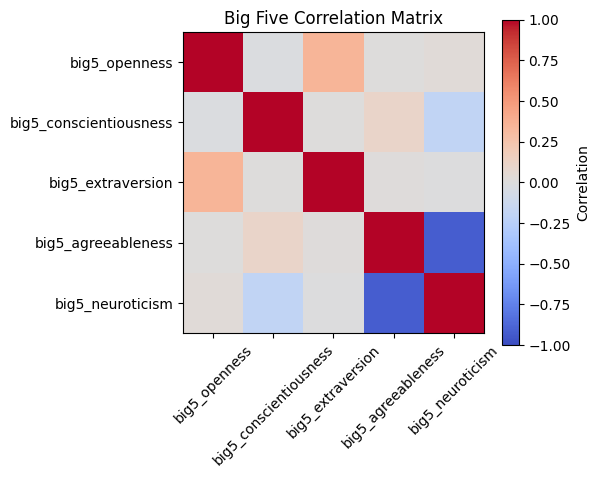

In [27]:
plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(big5_cols)), big5_cols, rotation=45)
plt.yticks(range(len(big5_cols)), big5_cols)
plt.colorbar(label="Correlation")
plt.title("Big Five Correlation Matrix")
plt.tight_layout()
plt.show()

### Feature Creation: Gender

In [28]:
category_features = [
    "restaurant_spend_share",
    "grocery_spend_share",
    "pharmacy_spend_share",
    "general_retail_spend_share",
    "family_spend_share",
    "fuel_spend_share"
]

big5_features = [
    "big5_openness",
    "big5_conscientiousness",
    "big5_extraversion",
    "big5_agreeableness",
    "big5_neuroticism"
]

# Combine all features we want to use for gender scoring
gender_signal_features = category_features + big5_features

In [29]:
user_features["gender_raw_score"] = (
    + user_features["grocery_spend_share"]        # Women tend to score higher
    + user_features["pharmacy_spend_share"]
    + user_features["family_spend_share"]
    + user_features["general_retail_spend_share"]
    + user_features["big5_agreeableness"] * 0.4   # Women higher on average
    + user_features["big5_neuroticism"] * 0.4     # Women higher on average
    - user_features["fuel_spend_share"] * 0.8     # Men tend to score higher
    - user_features["restaurant_spend_share"] * 0.2  # Sometimes slightly male-skewed online
)

In [30]:
user_features["gender_prob_female"] = 1 / (1 + np.exp(-user_features["gender_raw_score"]))
user_features["gender_prob_male"] = 1 - user_features["gender_prob_female"]

In [31]:
user_features["gender_label"] = np.where(
    user_features["gender_prob_female"] >= 0.5,
    "female",
    "male"
)

In [32]:
# Gender

gender_features = [
    "gender_prob_female",
    "gender_prob_male",
    "gender_label"
]

In [33]:
print("Gender:")
display(user_features[gender_features].head())

Gender:


,gender_prob_female,gender_prob_male,gender_label
0,0.624562,0.375438,female
1,0.583155,0.416845,female
2,0.611459,0.388541,female
3,0.734917,0.265083,female
4,0.742369,0.257631,female


In [34]:
display(user_features["gender_label"].value_counts())

gender_label
female    24287
male         34
Name: count, dtype: int64

### Feature Creation: Age

In [35]:
# Raw proxies
family_minus_social = user_features["family_spend_share"] - user_features["restaurant_spend_share"]
age_p1 = min_max_scale(family_minus_social)

log_total_spend = np.log1p(user_features["total_spend"])
age_p2 = min_max_scale(log_total_spend)

age_p3 = min_max_scale(user_features["loyalty_txn_fraction"])

In [36]:
# Combine into age_score
user_features["age_score"] = (age_p1 + age_p2 + age_p3) / 3.0

In [37]:
# Age groups via quantiles (relative to this population)
q = user_features["age_score"].quantile([0.25, 0.5, 0.75])
q25, q50, q75 = q[0.25], q[0.5], q[0.75]

def assign_age_group(score):
    if score <= q25:
        return "young_adult"
    elif score <= q50:
        return "early_middle"
    elif score <= q75:
        return "middle"
    else:
        return "older"

user_features["age_group"] = user_features["age_score"].apply(assign_age_group)

In [38]:
print("Age:")
display(user_features[["age_score", "age_group"]].head())

Age:


,age_score,age_group
0,0.350124,young_adult
1,0.301812,young_adult
2,0.731333,older
3,0.429729,middle
4,0.434983,middle


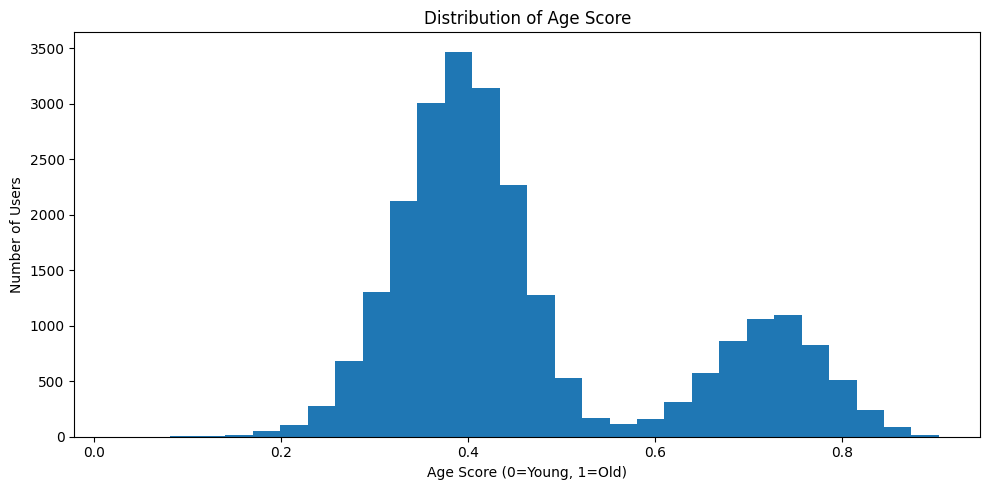

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["age_score"], bins=30)
plt.title("Distribution of Age Score")
plt.xlabel("Age Score (0=Young, 1=Old)")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

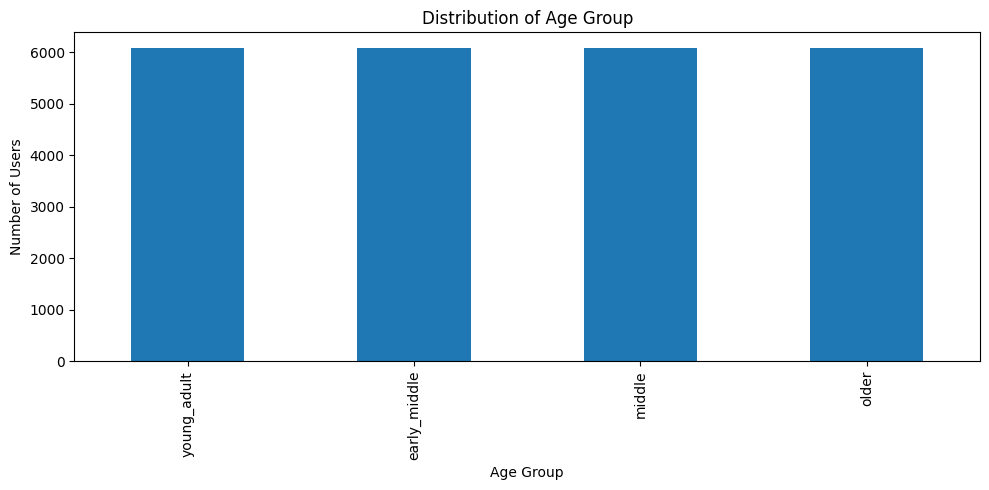

In [40]:
order = ["young_adult", "early_middle", "middle", "older"]

plt.figure(figsize=(10, 5))
user_features["age_group"].value_counts().reindex(order).plot(kind="bar")
plt.title("Distribution of Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Income Level

In [41]:
income_p1 = min_max_scale(np.log1p(user_features["total_spend"]))
income_p2 = min_max_scale(user_features["avg_transaction_amount"])
income_p3 = min_max_scale(user_features["credit_card_txn_fraction"])

In [42]:
if "city_Jakarta_share" in user_features.columns:
    income_p4 = min_max_scale(user_features["city_Jakarta_share"])
else:
    income_p4 = pd.Series(0.5, index=user_features.index)

user_features["income_score"] = (income_p1 + income_p2 + income_p3 + income_p4) / 4.0

In [43]:
# Income bands via quantiles
iq = user_features["income_score"].quantile([0.25, 0.5, 0.75])
i25, i50, i75 = iq[0.25], iq[0.5], iq[0.75]

def assign_income_level(score):
    if score <= i25:
        return "low"
    elif score <= i50:
        return "lower_mid"
    elif score <= i75:
        return "upper_mid"
    else:
        return "high"

user_features["income_level"] = user_features["income_score"].apply(assign_income_level)

In [44]:
print("Income:")
display(user_features[["income_score", "income_level"]].head())

Income:


,income_score,income_level
0,0.468832,high
1,0.283954,low
2,0.454159,high
3,0.289496,low
4,0.460938,high


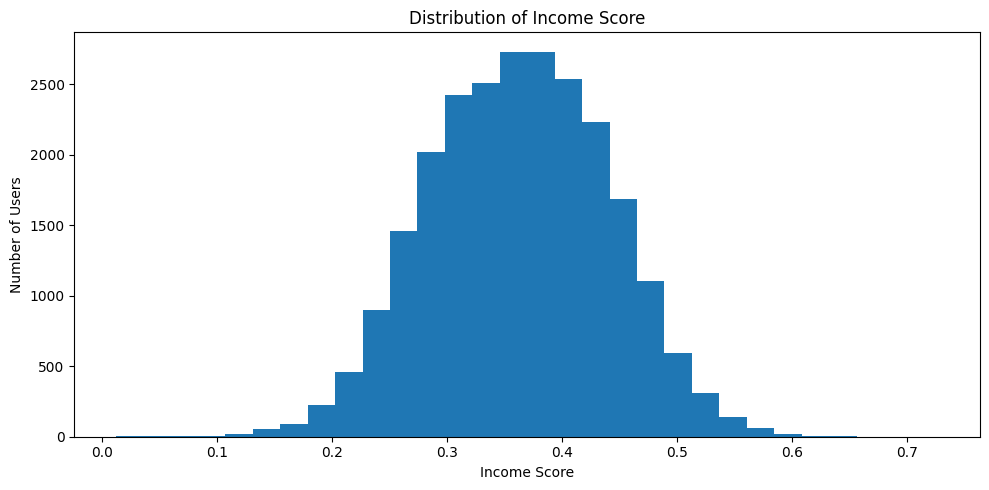

In [45]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["income_score"], bins=30)
plt.title("Distribution of Income Score")
plt.xlabel("Income Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

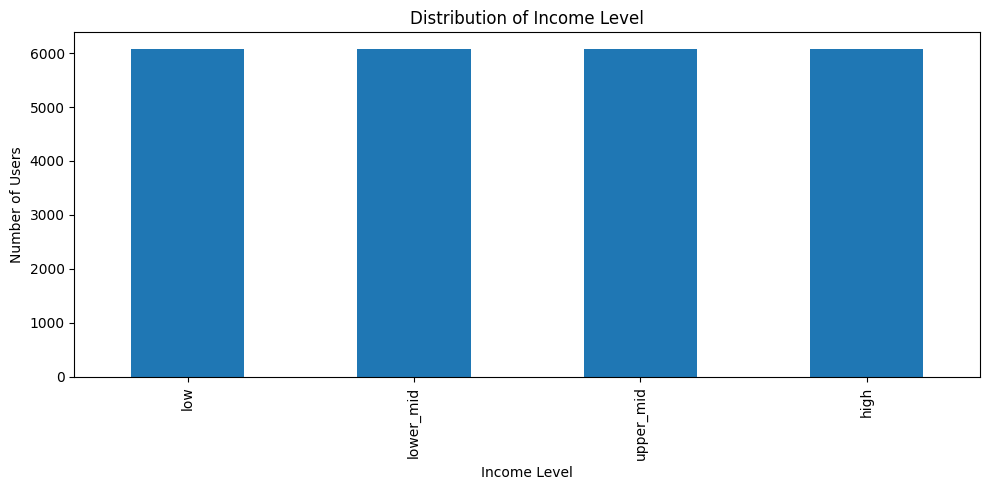

In [46]:
order = ["low", "lower_mid", "upper_mid", "high"]

plt.figure(figsize=(10, 5))
user_features["income_level"].value_counts().reindex(order).plot(kind="bar")
plt.title("Distribution of Income Level")
plt.xlabel("Income Level")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Educational Background

In [47]:
edu_p1 = min_max_scale(user_features["category_entropy"])
edu_p2 = min_max_scale(user_features["merchant_entropy"])
edu_p3 = min_max_scale(user_features["income_score"])
edu_p4 = min_max_scale(user_features["loyalty_txn_fraction"])

user_features["education_score"] = (edu_p1 + edu_p2 + edu_p3 + edu_p4) / 4.0

eq = user_features["education_score"].quantile([0.33, 0.66])
e33, e66 = eq[0.33], eq[0.66]

In [48]:
def assign_edu_level(score):
    if score <= e33:
        return "low"
    elif score <= e66:
        return "medium"
    else:
        return "high"

user_features["education_level"] = user_features["education_score"].apply(assign_edu_level)

In [49]:
print("Education:")
display(user_features[["education_score", "education_level"]].head())

Education:


,education_score,education_level
0,0.528411,high
1,0.398437,low
2,0.740104,high
3,0.416431,low
4,0.518231,medium


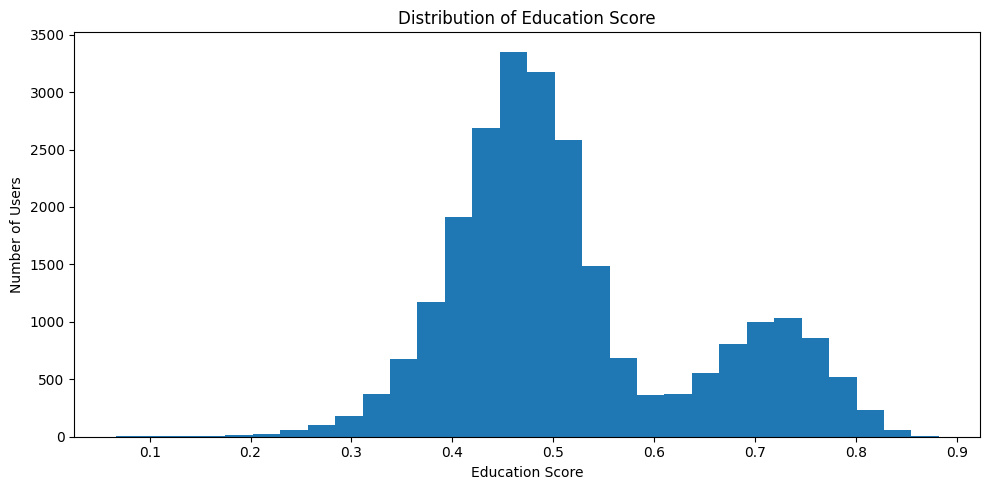

In [50]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["education_score"], bins=30)
plt.title("Distribution of Education Score")
plt.xlabel("Education Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

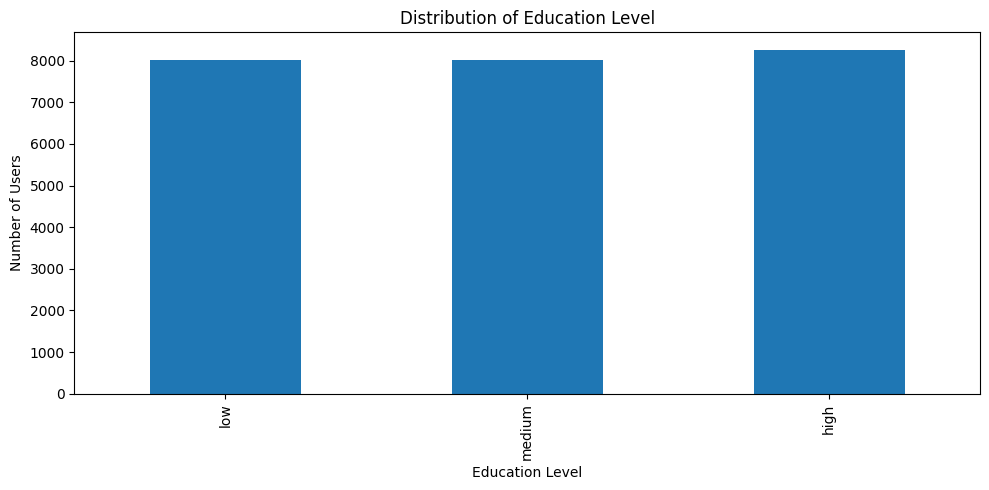

In [51]:
order = ["low", "medium", "high"]

plt.figure(figsize=(10, 5))
user_features["education_level"].value_counts().reindex(order).plot(kind="bar")
plt.title("Distribution of Education Level")
plt.xlabel("Education Level")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Home Location

In [52]:
user_features["home_city"] = user_features["primary_city"]
user_features["home_lat"] = user_features["centroid_lat"]
user_features["home_lon"] = user_features["centroid_lon"]

In [ ]:
# display(user_features["home_city"].value_counts())

In [53]:
print("Home Location:")
display(user_features[["home_city", "home_lat", "home_lon"]].head())

Home Location:


,home_city,home_lat,home_lon
0,Jakarta,-6.290074,106.814729
1,Surabaya,-7.538468,112.702112
2,Bekasi,-6.235291,106.844590
3,Bekasi,-6.317355,106.811432
4,Jakarta,-6.270892,106.781261


### Feature Creation: Work Location

In [54]:
# Make sure all city_share columns are numeric
city_share_cols = [c for c in user_features.columns
                if c.startswith("city_") and c.endswith("_share")]

user_features[city_share_cols] = user_features[city_share_cols].apply(
    pd.to_numeric, errors="coerce"
)

In [55]:
def infer_work_city(row):
    if row["n_cities"] <= 1:
        return row["home_city"]

    # Coerce row slice to numeric to avoid dtype object issues
    shares = pd.to_numeric(row[city_share_cols], errors="coerce")

    # If all shares are NaN or there is only one, fall back
    if shares.notna().sum() < 2:
        return row["home_city"]

    top2 = shares.nlargest(2)
    second_city_col = top2.index[1]

    return second_city_col.replace("city_", "").replace("_share", "")

def infer_work_reliability(row):
    return row["n_cities"] > 1

In [56]:
user_features["work_city"] = user_features.apply(infer_work_city, axis=1)
user_features["work_location_reliable"] = user_features.apply(
    infer_work_reliability, axis=1
)

In [ ]:
# display(user_features["work_city"].value_counts())

In [57]:
print("Work Location:")
display(user_features[["home_city", "work_city", "n_cities", "work_location_reliable"]].head())

Work Location:


,home_city,work_city,n_cities,work_location_reliable
0,Jakarta,Bogor,3,True
1,Surabaya,Malang,2,True
2,Bekasi,Jakarta,4,True
3,Bekasi,Bogor,5,True
4,Jakarta,Depok,4,True


### 2nd Priority

### Feature Creation: Working Status

In [58]:
def infer_working_status(row):
    weekend = row["weekend_txn_fraction"]
    income = row["income_score"]
    n_txn = row["n_transactions"]
    recency = row["recency_days"]
    
    # Very low engagement and long recency
    if n_txn < 5 and recency > 40:
        return "inactive_or_unemployed"
    
    # Higher income, moderate-to-high activity, more weekday than weekend
    if income > 0.6 and n_txn >= 10 and weekend < 0.4:
        return "full_time_or_professional"
    
    # Lower income, weekend-heavy behaviour
    if income < 0.4 and weekend > 0.5:
        return "student_or_part_time"
    
    return "flexible_or_unknown"

In [59]:
user_features["working_status"] = user_features.apply(infer_working_status, axis=1)

In [ ]:
# display(user_features["working_status"].value_counts())

In [60]:
print("Working Status:")
display(user_features[["working_status", "income_score", "weekend_txn_fraction", "n_transactions", "recency_days"]].head())

Working Status:


,working_status,income_score,weekend_txn_fraction,n_transactions,recency_days
0,flexible_or_unknown,0.468832,0.272727,11,19
1,flexible_or_unknown,0.283954,0.400000,10,41
2,flexible_or_unknown,0.454159,0.272727,11,10
3,student_or_part_time,0.289496,0.666667,9,19
4,flexible_or_unknown,0.460938,0.400000,10,33


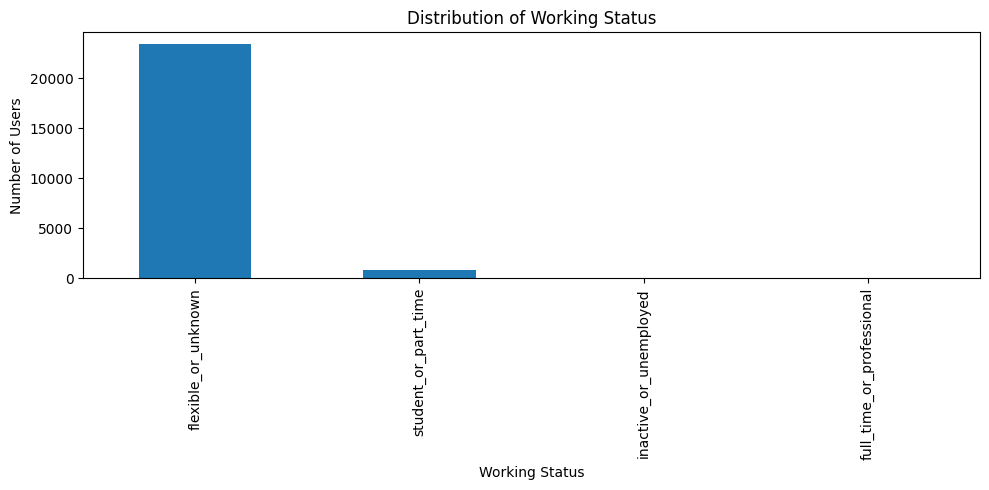

In [76]:
plt.figure(figsize=(10, 5))
user_features["working_status"].value_counts().plot(kind="bar")
plt.title("Distribution of Working Status")
plt.xlabel("Working Status")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Industry of Employment

In [65]:
# Pick dominant MCC by spend among top 10 MCCs we already have columns for
mcc_spend_cols = [c for c in user_features.columns if c.startswith("cat_") and c.endswith("_spend_share")]

In [68]:
def infer_dominant_mcc(row):
    share_cols = [c for c in row.index
                if c.startswith("cat_") and c.endswith("_spend_share")]
    shares = row[share_cols]

    # Force numeric; invalid entries become NaN
    shares = pd.to_numeric(shares, errors="coerce")

    if shares.isna().all():
        return np.nan
    
    col = shares.idxmax()
    # "cat_XXXX_spend_share" -> XXXX
    return int(col.replace("cat_", "").replace("_spend_share", ""))

In [69]:
user_features["dominant_mcc"] = user_features.apply(infer_dominant_mcc, axis=1)

In [70]:
# Map MCC to coarse industry
mcc_to_industry = {
    5411: "retail_grocery",
    5412: "retail_grocery",
    5812: "hospitality_food",
    5814: "hospitality_food",
    5912: "health_pharmacy",
    5732: "electronics_media",
    5999: "general_retail",
    5942: "books_stationery",
    5541: "transport_auto",
    5251: "home_improvement",
}

def map_industry(mcc):
    if np.isnan(mcc):
        return "unknown"
    return mcc_to_industry.get(int(mcc), "other")

In [71]:
user_features["industry_affinity"] = user_features["dominant_mcc"].apply(map_industry)

In [74]:
# display(user_features["industry_affinity"].value_counts())

In [72]:
print("Industry of Employment:")
display(user_features[["dominant_mcc", "industry_affinity"]].head())

Industry of Employment:


,dominant_mcc,industry_affinity
0,5814,hospitality_food
1,5814,hospitality_food
2,5814,hospitality_food
3,5412,retail_grocery
4,5942,books_stationery


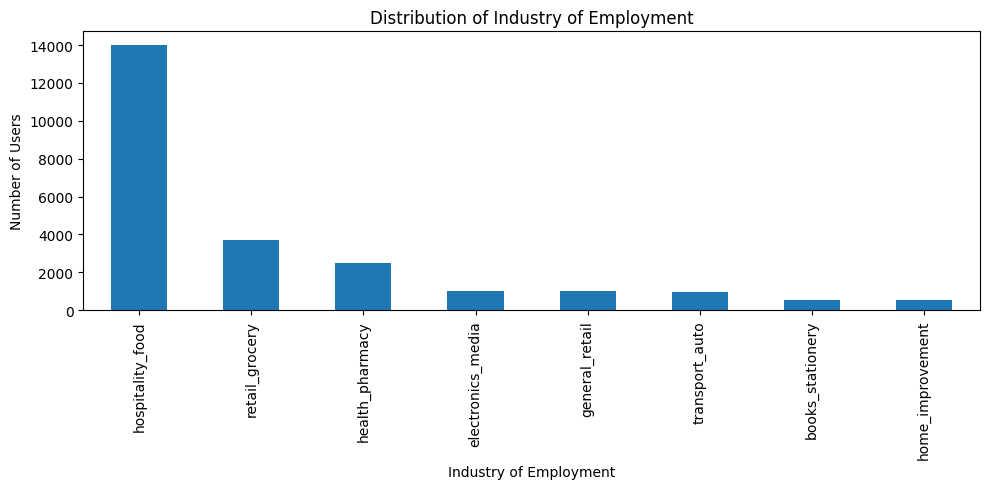

In [75]:
plt.figure(figsize=(10, 5))
user_features["industry_affinity"].value_counts().plot(kind="bar")
plt.title("Distribution of Industry of Employment")
plt.xlabel("Industry of Employment")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Health Status

In [ ]:
health_positive = user_features["pharmacy_spend_share"] + 0.5 * user_features["grocery_spend_share"]
health_negative = user_features["restaurant_spend_share"]

In [78]:
health_raw = health_positive - health_negative
user_features["health_behavior_score"] = min_max_scale(health_raw)

In [79]:
def assign_health_label(score):
    if score >= 0.66:
        return "health_oriented"
    elif score <= 0.33:
        return "less_health_oriented"
    else:
        return "neutral"

In [80]:
user_features["health_status"] = user_features["health_behavior_score"].apply(assign_health_label)

In [81]:
print("Health Status:")
display(user_features[["health_behavior_score", "health_status"]].head())

Health Status:


,health_behavior_score,health_status
0,0.338496,neutral
1,0.252015,less_health_oriented
2,0.329624,less_health_oriented
3,0.546473,neutral
4,0.504438,neutral


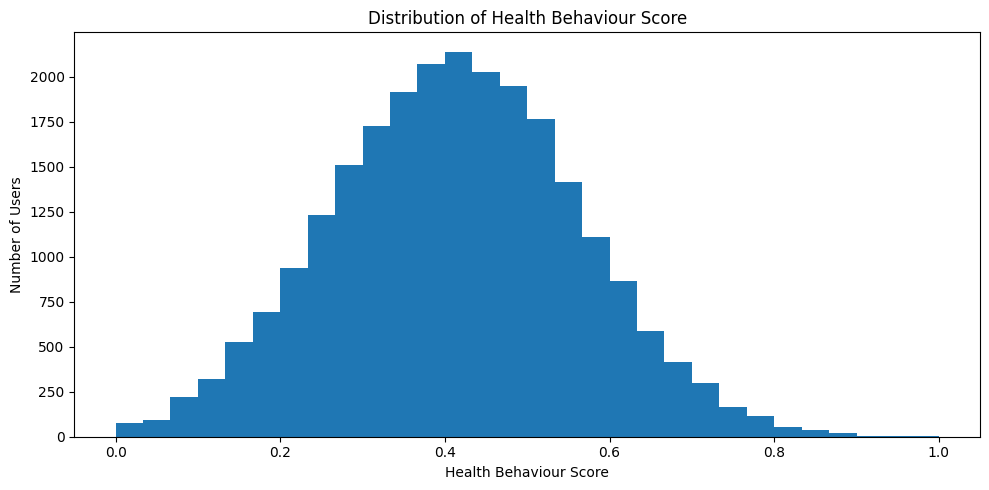

In [82]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["health_behavior_score"], bins=30)
plt.title("Distribution of Health Behaviour Score")
plt.xlabel("Health Behaviour Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

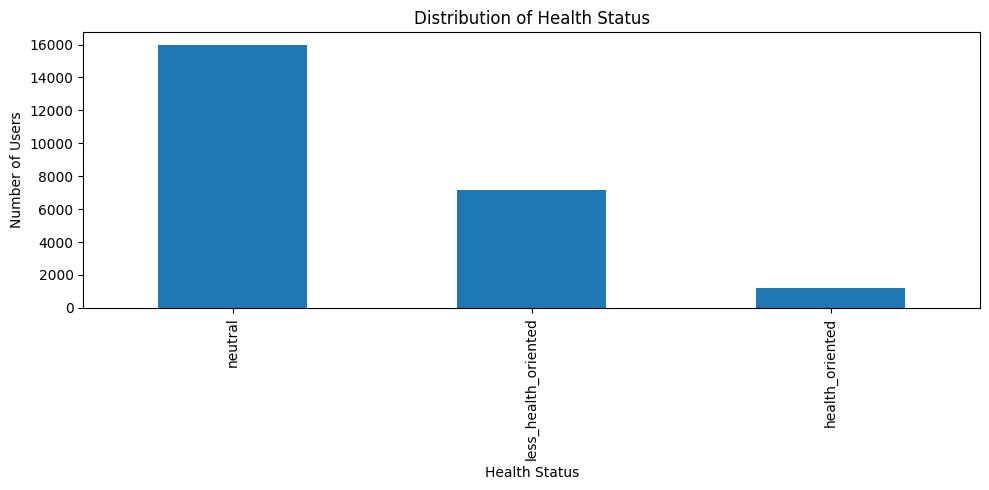

In [83]:
plt.figure(figsize=(10, 5))
user_features["health_status"].value_counts().plot(kind="bar")
plt.title("Distribution of Health Status")
plt.xlabel("Health Status")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Homeownership Status

In [84]:
user_features["homeownership_status"] = "unknown"

In [85]:
print("Homeownership Status:")
display(user_features[["homeownership_status"]].head())

Homeownership Status:


,homeownership_status
0,unknown
1,unknown
2,unknown
3,unknown
4,unknown


### Feature Creation: Marital Status

In [86]:
marital_raw = family_minus_social + user_features["age_score"]
user_features["marital_score"] = min_max_scale(marital_raw)

In [87]:
def assign_marital_status(score):
    if score >= 0.7:
        return "married_or_partnered_likely"
    elif score <= 0.3:
        return "single_likely"
    else:
        return "unknown"

In [88]:
user_features["marital_status"] = user_features["marital_score"].apply(assign_marital_status)

In [89]:
print("Marital Status:")
display(user_features[["marital_score", "marital_status"]].head())

Marital Status:


,marital_score,marital_status
0,0.327234,unknown
1,0.255160,single_likely
2,0.471131,unknown
3,0.559375,unknown
4,0.479750,unknown


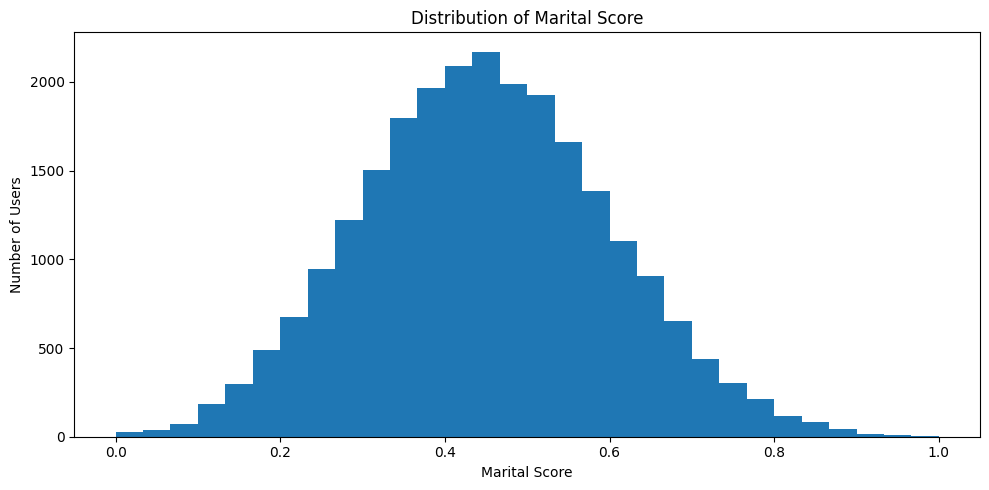

In [90]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["marital_score"], bins=30)
plt.title("Distribution of Marital Score")
plt.xlabel("Marital Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

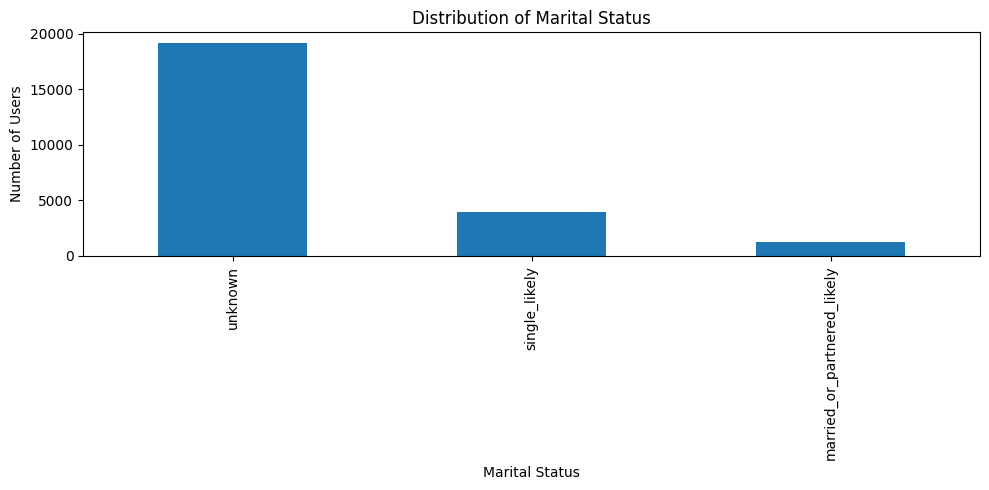

In [91]:
plt.figure(figsize=(10, 5))
user_features["marital_status"].value_counts().plot(kind="bar")
plt.title("Distribution of Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Parental Status

In [92]:
parent_raw = user_features["family_spend_share"] * user_features["age_score"]
user_features["parental_score"] = min_max_scale(parent_raw)

In [93]:
def assign_parental_status(score):
    if score >= 0.7:
        return "parent_likely"
    elif score <= 0.3:
        return "non_parent_likely"
    else:
        return "unknown"

In [94]:
user_features["parental_status"] = user_features["parental_score"].apply(assign_parental_status)

In [95]:
print("Parental Status:")
display(user_features[["parental_score", "parental_status"]].head())

Parental Status:


,parental_score,parental_status
0,0.027900,non_parent_likely
1,0.012959,non_parent_likely
2,0.130199,non_parent_likely
3,0.160352,non_parent_likely
4,0.034908,non_parent_likely


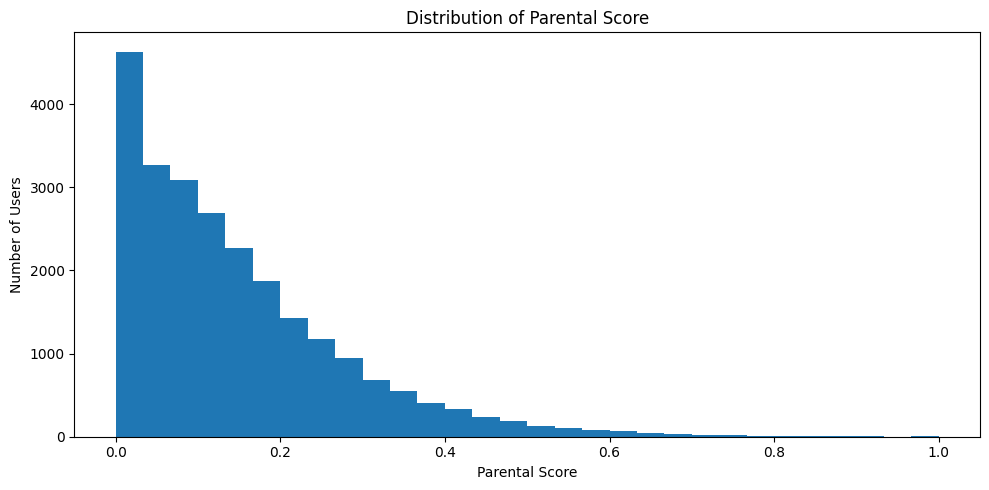

In [96]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["parental_score"], bins=30)
plt.title("Distribution of Parental Score")
plt.xlabel("Parental Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

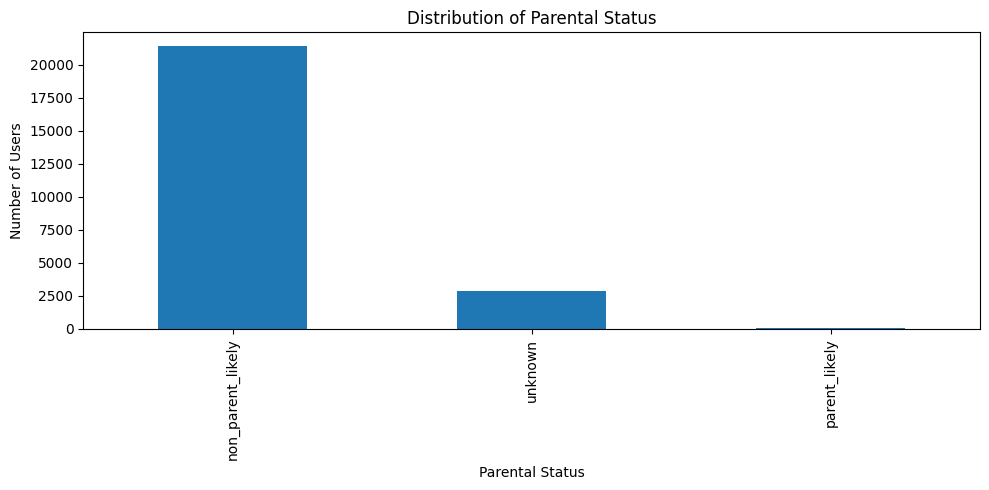

In [97]:
plt.figure(figsize=(10, 5))
user_features["parental_status"].value_counts().plot(kind="bar")
plt.title("Distribution of Parental Status")
plt.xlabel("Parental Status")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Feature Creation: Vehicle Ownership

In [98]:
veh_signal = user_features["fuel_spend_share"]
user_features["vehicle_ownership_score"] = min_max_scale(veh_signal)

In [99]:
def assign_vehicle_status(score):
    if score >= 0.6:
        return "owner_likely"
    elif score <= 0.1:
        return "non_owner_likely"
    else:
        return "unknown"

In [100]:
user_features["vehicle_ownership"] = user_features["vehicle_ownership_score"].apply(assign_vehicle_status)

In [101]:
print("Vehicle Ownership:")
display(user_features[["vehicle_ownership_score", "vehicle_ownership"]].head())

Vehicle Ownership:


,vehicle_ownership_score,vehicle_ownership
0,0.048304,non_owner_likely
1,0.067558,non_owner_likely
2,0.247662,unknown
3,0.000000,non_owner_likely
4,0.000000,non_owner_likely


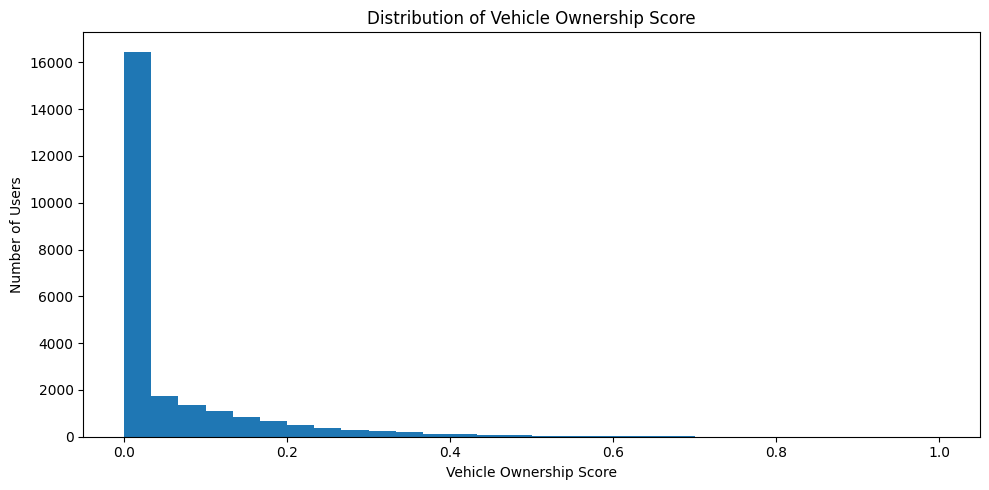

In [102]:
plt.figure(figsize=(10, 5))
plt.hist(user_features["vehicle_ownership_score"], bins=30)
plt.title("Distribution of Vehicle Ownership Score")
plt.xlabel("Vehicle Ownership Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

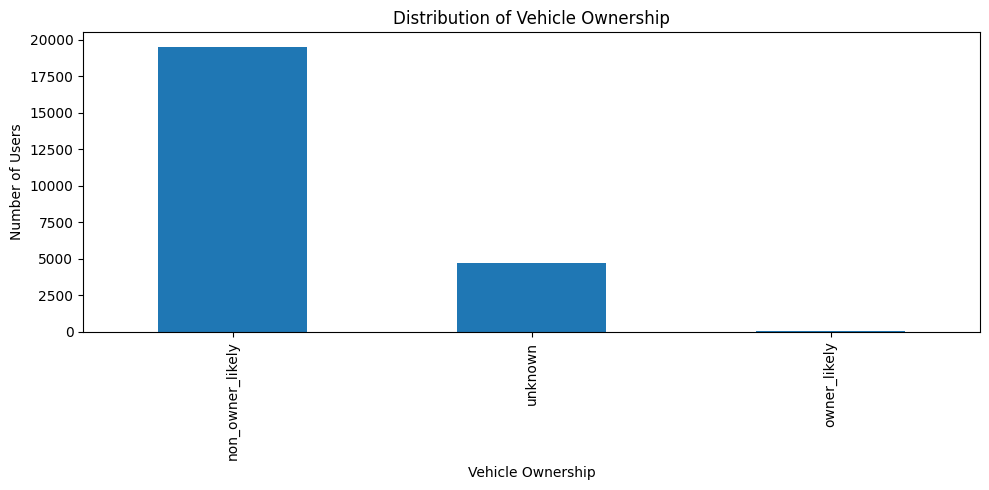

In [103]:
plt.figure(figsize=(10, 5))
user_features["vehicle_ownership"].value_counts().plot(kind="bar")
plt.title("Distribution of Vehicle Ownership")
plt.xlabel("Vehicle Ownership")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

### Data Checking

In [104]:
print("User-Level Features:", user_features.shape)
print(user_features.head())
# display(user_features.head())

User-Level Features: (24321, 127)
   n_transactions  total_spend  avg_transaction_amount  median_transaction_amount  std_transaction_amount  \
0              11     514600.0            46781.818182                    33800.0            40790.509146   
1              10     364500.0            36450.000000                    19650.0            34786.946786   
2              11    1007900.0            91627.272727                    83700.0            75100.214259   
3               9     430800.0            47866.666667                    22500.0            53745.162573   
4              10     795200.0            79520.000000                    43550.0           105402.274907   

   max_transaction_amount  min_transaction_amount  cv_transaction_amount  n_completed  completion_rate  n_refunded  \
0                156600.0                 14300.0               0.871931           11              1.0           0   
1                105100.0                  2200.0               0.954374   

In [105]:
print(user_features.isnull().sum())
# display(user_features.isnull().sum())

n_transactions               0
total_spend                  0
avg_transaction_amount       0
median_transaction_amount    0
std_transaction_amount       0
                            ..
marital_status               0
parental_score               0
parental_status              0
vehicle_ownership_score      0
vehicle_ownership            0
Length: 127, dtype: int64


In [106]:
display(user_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24321 entries, 0 to 24320
Columns: 127 entries, n_transactions to vehicle_ownership
dtypes: bool(1), datetime64[ns](2), float64(89), int32(8), int64(12), object(15)
memory usage: 22.7+ MB


None

### Data Exporting

In [107]:
# user_features.to_csv('./data/transactions_eda_ulf.csv', index=False)
user_features.to_parquet("./data/transactions_eda_df.parquet", index=False)

In [109]:
%reset -f

## Feature Engineering: Total Features (for Segmentation)

In [1]:
%reset -f

In [20]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Data Importing

In [3]:
# user_features = pd.read_csv('./data/transactions_eda_df.csv')
user_features = pd.read_parquet('./data/transactions_eda_df.parquet')

In [4]:
display(user_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24321 entries, 0 to 24320
Columns: 127 entries, n_transactions to vehicle_ownership
dtypes: bool(1), datetime64[ns](2), float64(89), int32(8), int64(12), object(15)
memory usage: 22.7+ MB


None

### Data Pre-Processing

In [5]:
user_features = user_features.copy()
user_features["user_index"] = np.arange(len(user_features))

In [6]:
print("user_features with user_index:", user_features.shape)
display(user_features[["user_index"]].head())

user_features with user_index: (24321, 128)


,user_index
0,0
1,1
2,2
3,3
4,4


### Data Segmentation

In [8]:
# Numeric features focused on behaviour + profile scores
seg_numeric_features = [
    # Spend / Volume + Completion / Refund + Temporal
    "n_transactions",
    "total_spend",
    "avg_transaction_amount",

    # Temporal
    "activity_span_days",
    "n_active_days",
    "avg_txn_per_active_day",
    "recency_days",
    "weekend_txn_fraction",
    "weekday_txn_fraction",

    # Merchant
    "restaurant_spend_share",
    "grocery_spend_share",
    "pharmacy_spend_share",
    "general_retail_spend_share",
    "fuel_spend_share",
    "family_spend_share",

    "n_distinct_categories",
    "n_distinct_merchants",
    "category_entropy",
    "merchant_entropy",
    "top_merchant_spend_share",

    # Location
    "n_distinct_locations",
    "avg_distance_from_centroid_km",

    # Payment
    "credit_card_txn_fraction",
    "balance_txn_fraction",
    "promo_to_spend_ratio",
    "loyalty_txn_fraction",

    # Ratings
    "avg_rating",
    "rating_std",
    "n_low_ratings",
    "n_high_ratings",

    # Big Five Personality Score
    "big5_openness",
    "big5_conscientiousness",
    "big5_extraversion",
    "big5_agreeableness",
    "big5_neuroticism",

    # Age
    "age_score",
    # Income Level
    "income_score",
    # Educational Background
    "education_score",
    # Health Status
    "health_behavior_score",
    # Vehicle Ownership
    "vehicle_ownership_score",
]

In [9]:
# Categorical features
seg_categorical_features = [
    # Home Location
    "home_city",
    # Work Location
    "work_city",
    # Working Status
    "working_status",
    # Industry of Employment
    "industry_affinity",
    # Income Level
    "income_level",
    # Age
    "age_group",
    # Educational Background
    "education_level",
    # Health Status
    "health_status",
    # Vehicle Ownership
    "vehicle_ownership",
    # Device
    "primary_device_family",
]

In [10]:
print("Number of Numeric Features:", len(seg_numeric_features))
print("Number of Categorical Features:", len(seg_categorical_features))

Number of Numeric Features: 40
Number of Categorical Features: 10


In [ ]:
# Build base segmentation DataFrame
seg_cols = seg_numeric_features + seg_categorical_features
segmentation_df = user_features[seg_cols].copy()

In [13]:
print("Segmentation DataFrame:", segmentation_df.shape)
display(segmentation_df.head())

Segmentation DataFrame: (24321, 50)


,n_transactions,total_spend,avg_transaction_amount,activity_span_days,n_active_days,avg_txn_per_active_day,recency_days,weekend_txn_fraction,weekday_txn_fraction,restaurant_spend_share,grocery_spend_share,pharmacy_spend_share,general_retail_spend_share,fuel_spend_share,family_spend_share,n_distinct_categories,n_distinct_merchants,category_entropy,merchant_entropy,top_merchant_spend_share,n_distinct_locations,avg_distance_from_centroid_km,credit_card_txn_fraction,balance_txn_fraction,promo_to_spend_ratio,loyalty_txn_fraction,avg_rating,rating_std,n_low_ratings,n_high_ratings,big5_openness,big5_conscientiousness,big5_extraversion,big5_agreeableness,big5_neuroticism,age_score,income_score,education_score,health_behavior_score,vehicle_ownership_score,home_city,work_city,working_status,industry_affinity,income_level,age_group,education_level,health_status,vehicle_ownership,primary_device_family
0,11,514600.0,46781.818182,67,9,1.222222,19,0.272727,0.727273,0.419161,0.000000,0.065682,0.071123,0.041586,0.065682,9,11,3.095795,3.459432,0.304314,11,15.023738,0.181818,0.818182,0.066848,0.0,3.818182,0.981650,1,7,0.526246,0.655363,0.397296,0.857143,0.201780,0.350124,0.468832,0.528411,0.338496,0.048304,Jakarta,Bogor,flexible_or_unknown,hospitality_food,high,young_adult,high,neutral,non_owner_likely,android
1,10,364500.0,36450.000000,45,9,1.111111,41,0.400000,0.600000,0.536351,0.035391,0.000000,0.000000,0.058162,0.035391,5,10,2.246439,3.321928,0.288340,10,38.458816,0.300000,0.700000,0.015364,0.0,3.900000,1.370320,2,8,0.509642,0.604697,0.395450,0.773016,0.273875,0.301812,0.283954,0.398437,0.252015,0.067558,Surabaya,Malang,flexible_or_unknown,hospitality_food,low,young_adult,low,less_health_oriented,non_owner_likely,android
2,11,1007900.0,91627.272727,70,11,1.000000,10,0.272727,0.727273,0.490525,0.053279,0.093462,0.000000,0.213216,0.146741,7,11,2.594907,3.459432,0.228197,11,13.739299,0.090909,0.909091,0.037206,1.0,4.272727,0.786245,0,9,0.544562,0.911073,0.504417,0.930736,0.140875,0.731333,0.454159,0.740104,0.329624,0.247662,Bekasi,Jakarta,flexible_or_unknown,hospitality_food,high,older,high,less_health_oriented,unknown,android
3,9,430800.0,47866.666667,61,9,1.000000,19,0.666667,0.333333,0.110028,0.307567,0.000000,0.000000,0.000000,0.307567,7,9,2.641604,3.169925,0.311978,9,20.997330,0.000000,1.000000,0.000000,0.0,3.444444,1.236033,2,6,0.594647,0.627977,0.592232,0.777778,0.288690,0.429729,0.289496,0.416431,0.546473,0.000000,Bekasi,Bogor,student_or_part_time,retail_grocery,low,middle,low,neutral,non_owner_likely,android
4,10,795200.0,79520.000000,53,10,1.000000,33,0.400000,0.600000,0.090166,0.025025,0.041122,0.507671,0.000000,0.066147,9,10,3.121928,3.321928,0.439261,10,15.286741,0.100000,0.900000,0.000000,0.0,3.700000,1.059350,1,5,0.563359,0.530853,0.413389,0.787302,0.303671,0.434983,0.460938,0.518231,0.504438,0.000000,Jakarta,Depok,flexible_or_unknown,books_stationery,high,middle,medium,neutral,non_owner_likely,android


In [14]:
# Replace inf with NaN on numeric columns, then fill with median
segmentation_df[seg_numeric_features] = (
    segmentation_df[seg_numeric_features]
    .replace([np.inf, -np.inf], np.nan)
)

In [15]:
numeric_medians = segmentation_df[seg_numeric_features].median()
segmentation_df[seg_numeric_features] = segmentation_df[seg_numeric_features].fillna(numeric_medians)

In [16]:
# Categorical: fill missing with 'unknown'
for col in seg_categorical_features:
    segmentation_df[col] = segmentation_df[col].fillna("unknown").astype(str)

### Data Visualization

In [18]:
key_hist_features = [
    "n_transactions", "total_spend", "avg_transaction_amount",
    "weekend_txn_fraction", "restaurant_spend_share",
    "grocery_spend_share", "loyalty_txn_fraction",
    "income_score", "age_score", "education_score",
]

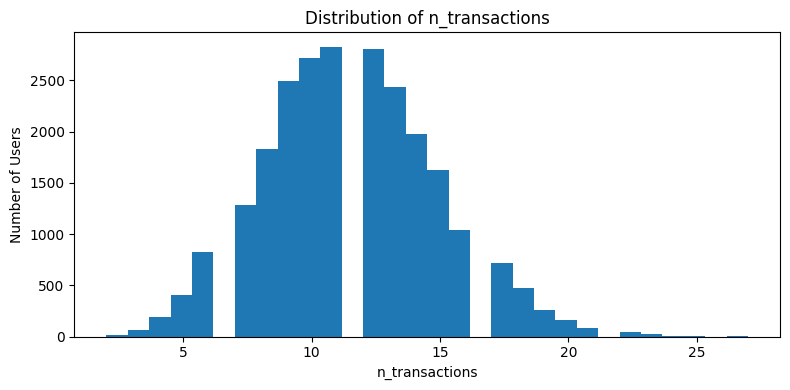

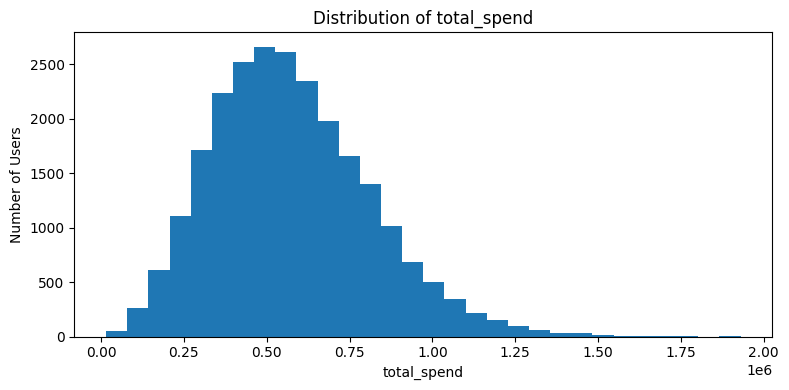

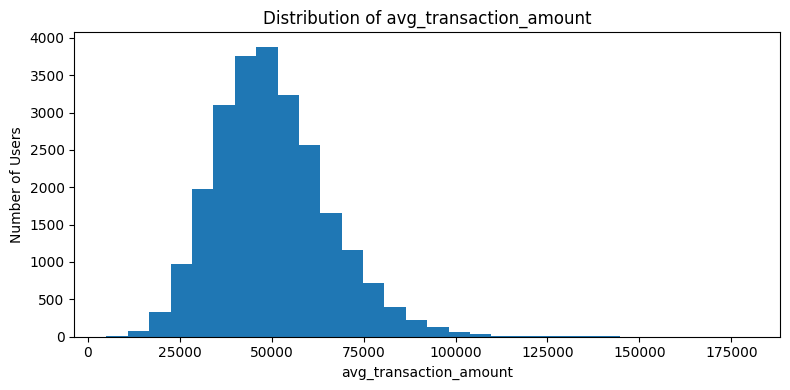

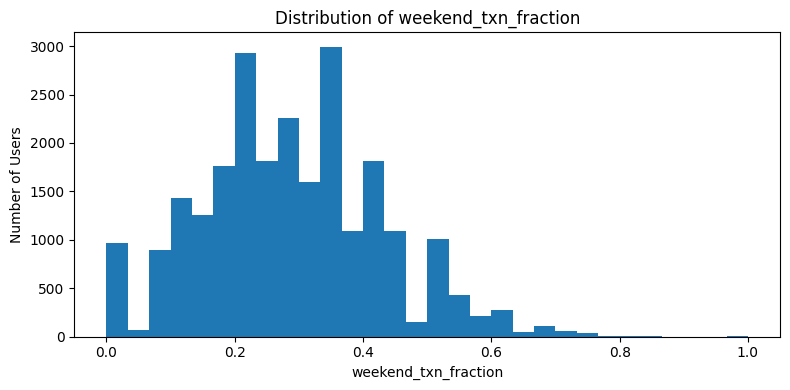

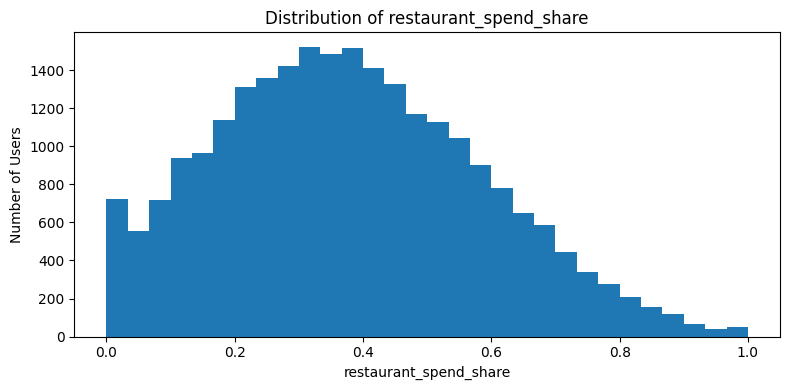

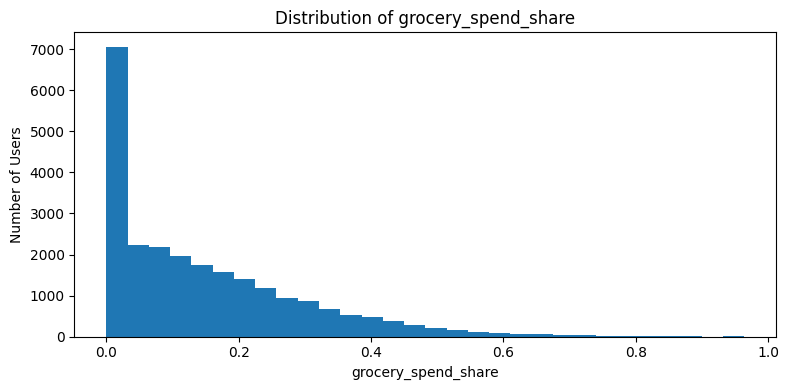

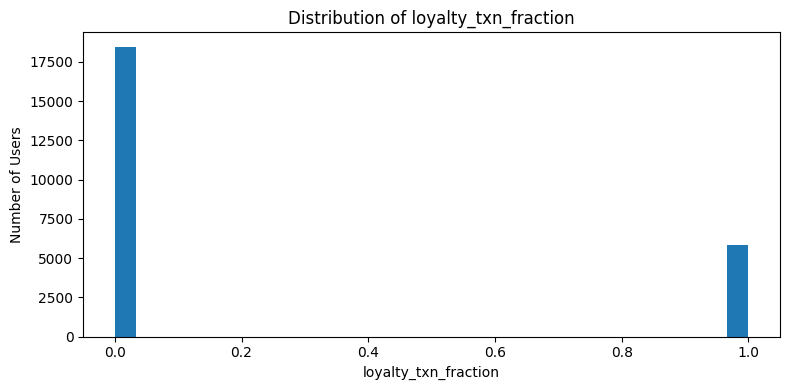

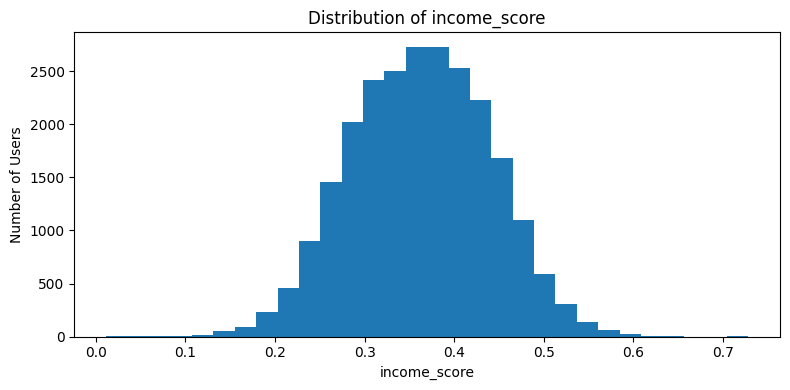

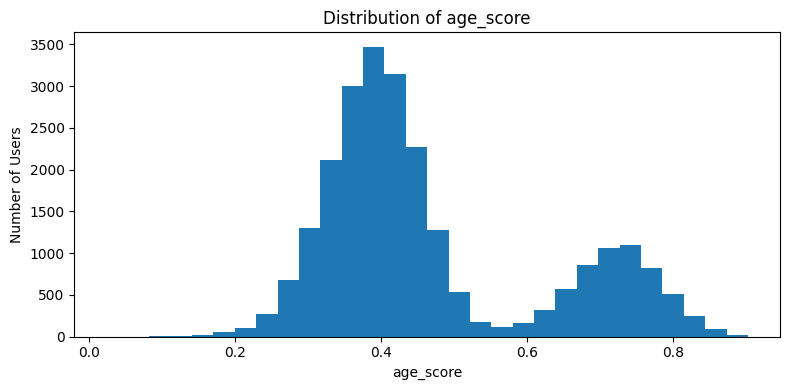

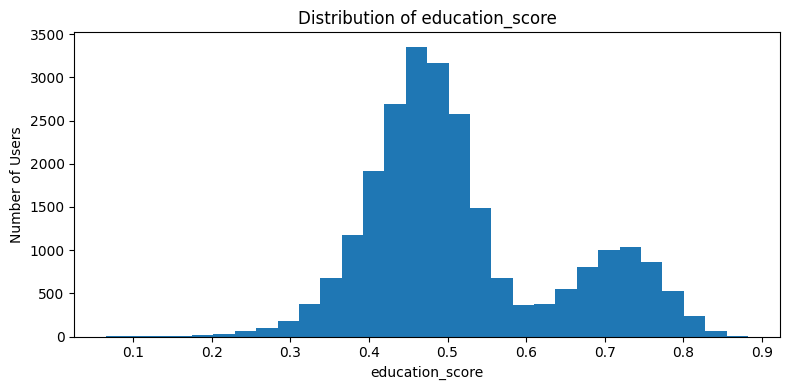

In [ ]:
for col in key_hist_features:
    if col not in segmentation_df.columns:
        continue
    plt.figure(figsize=(10, 5))
    plt.hist(segmentation_df[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Number of Users")
    plt.tight_layout()
    plt.show()

### Data Scaling & Data Encoding

In [21]:
# Standardize numeric features (mean 0, std 1)
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(segmentation_df[seg_numeric_features])

In [24]:
print("Shape of Scaled Numeric Features:", X_numeric_scaled.shape)

Shape of Scaled Numeric Features: (24321, 40)


In [23]:
# One-hot encode categorical features
X_categorical = pd.get_dummies(
    segmentation_df[seg_categorical_features],
    drop_first=False
)

In [25]:
print("Shape of Scaled Categorical Features", X_categorical.shape)

Shape of Scaled Categorical Features (24321, 50)


In [26]:
# Combine numeric + categorical into one matrix
X_combined = np.hstack([X_numeric_scaled, X_categorical.values])
seg_feature_names = seg_numeric_features + list(X_categorical.columns)

X = pd.DataFrame(
    X_combined,
    columns=seg_feature_names,
    index=user_features.index
)

In [27]:
print("Shape of Combined Features:", X.shape)
display(X.head())

Shape of Combined Features: (24321, 90)


,n_transactions,total_spend,avg_transaction_amount,activity_span_days,n_active_days,avg_txn_per_active_day,recency_days,weekend_txn_fraction,weekday_txn_fraction,restaurant_spend_share,grocery_spend_share,pharmacy_spend_share,general_retail_spend_share,fuel_spend_share,family_spend_share,n_distinct_categories,n_distinct_merchants,category_entropy,merchant_entropy,top_merchant_spend_share,n_distinct_locations,avg_distance_from_centroid_km,credit_card_txn_fraction,balance_txn_fraction,promo_to_spend_ratio,...,industry_affinity_health_pharmacy,industry_affinity_home_improvement,industry_affinity_hospitality_food,industry_affinity_retail_grocery,industry_affinity_transport_auto,income_level_high,income_level_low,income_level_lower_mid,income_level_upper_mid,age_group_early_middle,age_group_middle,age_group_older,age_group_young_adult,education_level_high,education_level_low,education_level_medium,health_status_health_oriented,health_status_less_health_oriented,health_status_neutral,vehicle_ownership_non_owner_likely,vehicle_ownership_owner_likely,vehicle_ownership_unknown,primary_device_family_android,primary_device_family_ipad,primary_device_family_iphone
0,-0.138853,-0.250381,-0.213343,-0.669541,-0.561318,1.747884,1.204621,-0.076167,0.076167,0.194161,-0.988669,-0.241487,-0.039175,-0.056052,-0.983083,0.967052,-0.130814,1.162355,0.027131,0.231959,-0.138853,-0.700199,-0.152968,0.152968,-0.201940,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.435060,-0.877107,-0.882256,-2.465087,-0.561318,0.465716,3.711210,0.828195,-0.828195,0.769517,-0.748659,-0.777643,-0.691330,0.131467,-1.152889,-1.150216,-0.428209,-0.841280,-0.272540,0.072654,-0.435060,1.312830,0.788333,-0.788333,-0.749513,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.138853,1.809338,2.690086,-0.424693,0.094184,-0.816451,0.179198,-0.076167,0.076167,0.544530,-0.627347,-0.014726,-0.691330,1.885518,-0.528684,-0.091582,-0.130814,-0.019244,0.027131,-0.527142,-0.138853,-0.810530,-0.877045,0.877045,-0.517202,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.731267,-0.600279,-0.143107,-1.159235,-0.561318,-0.816451,1.204621,2.723048,-2.723048,-1.323548,1.097156,-0.777643,-0.691330,-0.526492,0.372879,-0.091582,-0.725604,0.090916,-0.603810,0.308387,-0.731267,-0.187079,-1.601123,1.601123,-0.912914,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.435060,0.921233,1.906224,-1.812161,-0.233567,-0.816451,2.799723,0.828195,-0.828195,-1.421061,-0.818957,-0.441971,3.963697,-0.526492,-0.980477,0.967052,-0.428209,1.224002,-0.272540,1.577758,-0.435060,-0.677608,-0.804638,0.804638,-0.912914,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Data Exporting

In [28]:
X.to_parquet("./data/transactions_eda_tf.parquet", index=False)

In [1]:
%reset -f

## Feature Segmentation

In [2]:
%reset -f

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

### Data Importing

In [4]:
user_features = pd.read_parquet('./data/transactions_eda_df.parquet')

In [5]:
display(user_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24321 entries, 0 to 24320
Columns: 127 entries, n_transactions to vehicle_ownership
dtypes: bool(1), datetime64[ns](2), float64(89), int32(8), int64(12), object(15)
memory usage: 22.7+ MB


None

In [6]:
X = pd.read_parquet('./data/transactions_eda_tf.parquet')

In [7]:
display(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24321 entries, 0 to 24320
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   n_transactions                            24321 non-null  float64
 1   total_spend                               24321 non-null  float64
 2   avg_transaction_amount                    24321 non-null  float64
 3   activity_span_days                        24321 non-null  float64
 4   n_active_days                             24321 non-null  float64
 5   avg_txn_per_active_day                    24321 non-null  float64
 6   recency_days                              24321 non-null  float64
 7   weekend_txn_fraction                      24321 non-null  float64
 8   weekday_txn_fraction                      24321 non-null  float64
 9   restaurant_spend_share                    24321 non-null  float64
 10  grocery_spend_share               

None

### Data Clustering w/ K-Means

In [8]:
k_values = [4, 5, 6, 7, 8, 9]
inertias = []
silhouette_scores = []

In [9]:
# Use a sample for silhouette to keep computation manageable
n_samples_for_sil = min(5000, X.shape[0])
rng = np.random.RandomState(42)
sample_indices = rng.choice(X.shape[0], size=n_samples_for_sil, replace=False)
X_sample = X.iloc[sample_indices]

In [10]:
for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    km.fit(X)

    inertias.append(km.inertia_)

    # Silhouette on the sample
    labels_sample = km.labels_[sample_indices]
    sil = silhouette_score(X_sample, labels_sample)
    silhouette_scores.append(sil)
    print(f"k={k}: inertia={km.inertia_:.2f}, silhouette={sil:.4f}")

k=4: inertia=865962.62, silhouette=0.1014
k=5: inertia=836614.59, silhouette=0.0744
k=6: inertia=813527.45, silhouette=0.0723
k=7: inertia=792739.12, silhouette=0.0671
k=8: inertia=772259.33, silhouette=0.0679
k=9: inertia=757991.23, silhouette=0.0645


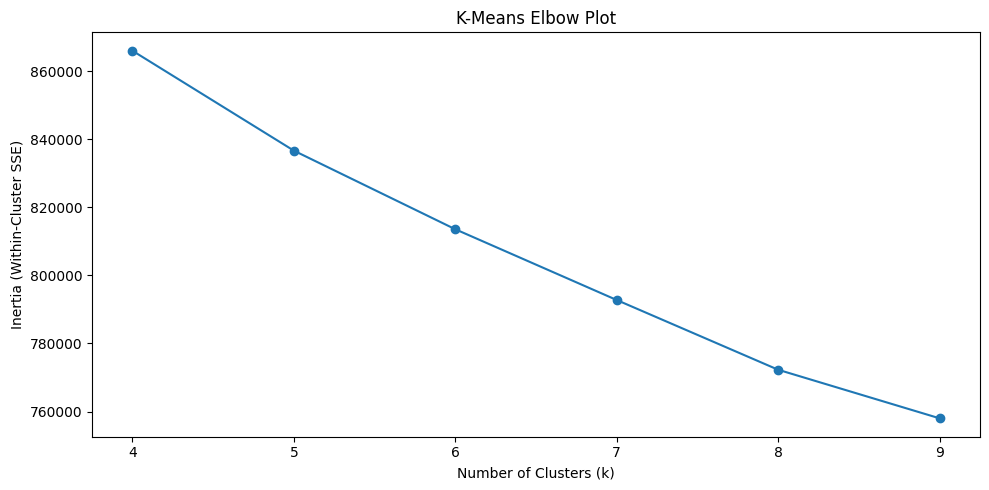

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertias, marker="o")
plt.title("K-Means Elbow Plot")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.xticks(k_values)
plt.tight_layout()
plt.show()

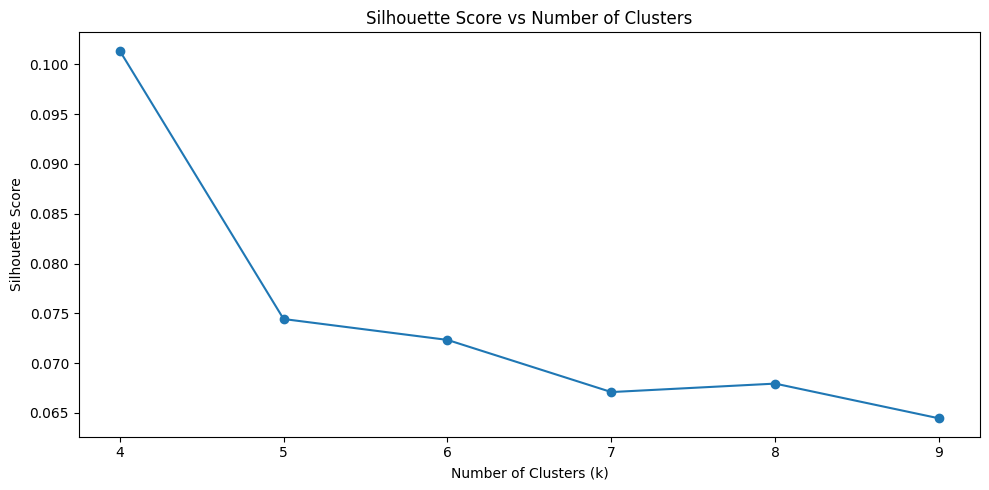

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker="o")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.tight_layout()
plt.show()

In [16]:
k_opt = 4
# It gives the highest silhouette score, indicating the most meaningful and well-separated clusters.
# Adding more clusters reduces silhouette quality without giving a clear elbow improvement.

kmeans_final = KMeans(
    n_clusters=k_opt,
    random_state=42,
    n_init=20,
    max_iter=500
)
kmeans_final.fit(X)

KMeans(max_iter=500, n_clusters=4, n_init=20, random_state=42)

In [18]:
cluster_labels = kmeans_final.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
for c, cnt in zip(unique, counts):
    print(f"Cluster {c}: {cnt} Users")

Cluster 0: 8923 Users
Cluster 1: 5455 Users
Cluster 2: 5089 Users
Cluster 3: 4854 Users


In [ ]:
user_features = user_features
user_features["cluster_kmeans"] = cluster_labels

In [20]:
print("user_features w/ Clusters:", user_features.shape)
display(user_features[["cluster_kmeans"]].head())

user_features w/ Clusters: (24321, 128)


,cluster_kmeans
0,0
1,2
2,3
3,1
4,1


In [27]:
cluster_profile_features = [
    # Spend / Volume + Completion / Refund + Temporal
    "n_transactions",
    "total_spend",
    "avg_transaction_amount",

    # Temporal
    "activity_span_days",
    "n_active_days",
    "avg_txn_per_active_day",
    "recency_days",
    "weekend_txn_fraction",
    "weekday_txn_fraction",

    # Merchant
    "restaurant_spend_share",
    "grocery_spend_share",
    "pharmacy_spend_share",
    "general_retail_spend_share",
    "fuel_spend_share",
    "family_spend_share",

    "n_distinct_categories",
    "n_distinct_merchants",
    "category_entropy",
    "merchant_entropy",
    "top_merchant_spend_share",

    # Location
    "n_distinct_locations",
    "avg_distance_from_centroid_km",

    # Payment
    "credit_card_txn_fraction",
    "balance_txn_fraction",
    "promo_to_spend_ratio",
    "loyalty_txn_fraction",

    # Big Five Personality Score
    "big5_openness",
    "big5_conscientiousness",
    "big5_extraversion",
    "big5_agreeableness",
    "big5_neuroticism",

    # Age
    "age_score",
    # Income Level
    "income_score",
    # Educational Background
    "education_score",
    # Health Status
    "health_behavior_score",
    # Vehicle Ownership
    "vehicle_ownership_score",
]

In [28]:
cluster_summary = (
    user_features
    .groupby("cluster_kmeans")[cluster_profile_features]
    .mean()
    .round(3)
)

In [42]:
print("Cluster Summary:", cluster_summary.shape)
print(cluster_summary)

Cluster Summary: (4, 36)
                n_transactions  total_spend  avg_transaction_amount  activity_span_days  n_active_days  \
cluster_kmeans                                                                                           
0                       14.162   724571.456               51403.550              79.574         13.074   
1                        8.800   426343.538               48769.223              70.727          8.370   
2                        8.790   423348.438               48368.226              70.241          8.342   
3                       12.327   623927.503               50899.907              77.402         11.489   

                avg_txn_per_active_day  recency_days  weekend_txn_fraction  weekday_txn_fraction  \
cluster_kmeans                                                                                     
0                                1.087         6.122                 0.286                 0.714   
1                                1.054

In [33]:
cat_profile_cols = [
    "income_level",
    "age_group",
    "working_status",
    "education_level",
    "health_status",
    "vehicle_ownership",
    "industry_affinity",
    "home_city",
    "work_city",
]

In [43]:
for col in cat_profile_cols:
    if col not in user_features.columns:
        continue
    print(f"\nCluster vs {col}")
    ct = pd.crosstab(
        user_features["cluster_kmeans"],
        user_features[col],
        normalize="index"
    ).round(3)
    print(ct)


Cluster vs income_level
income_level     high    low  lower_mid  upper_mid
cluster_kmeans                                    
0               0.327  0.146      0.240      0.286
1               0.157  0.388      0.250      0.204
2               0.187  0.324      0.266      0.223
3               0.278  0.208      0.251      0.263

Cluster vs age_group
age_group       early_middle  middle  older  young_adult
cluster_kmeans                                          
0                      0.406   0.414  0.014        0.166
1                      0.361   0.435  0.110        0.094
2                      0.095   0.003  0.099        0.803
3                      0.000   0.000  1.000        0.000

Cluster vs working_status
working_status  flexible_or_unknown  full_time_or_professional  inactive_or_unemployed  student_or_part_time
cluster_kmeans                                                                                              
0                             0.980                        0

### Data Visualization w/ PCA

In [38]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

In [39]:
print("PCA Explained Variance Ratios:", pca.explained_variance_ratio_)

PCA Explained Variance Ratios: [0.20516608 0.09291458]


In [44]:
pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"],
    index=user_features.index
)
pca_df["cluster_kmeans"] = cluster_labels

cluster_pca_means = (
    pca_df.groupby("cluster_kmeans")[["PC1", "PC2"]].mean()
)

In [45]:
print("Cluster Centroids in PCA:")
display(cluster_pca_means.round(3))

Cluster Centroids in PCA:


,PC1,PC2
cluster_kmeans,,
0,2.305,-0.946
1,-2.367,1.146
2,-2.928,-1.832
3,1.492,2.372


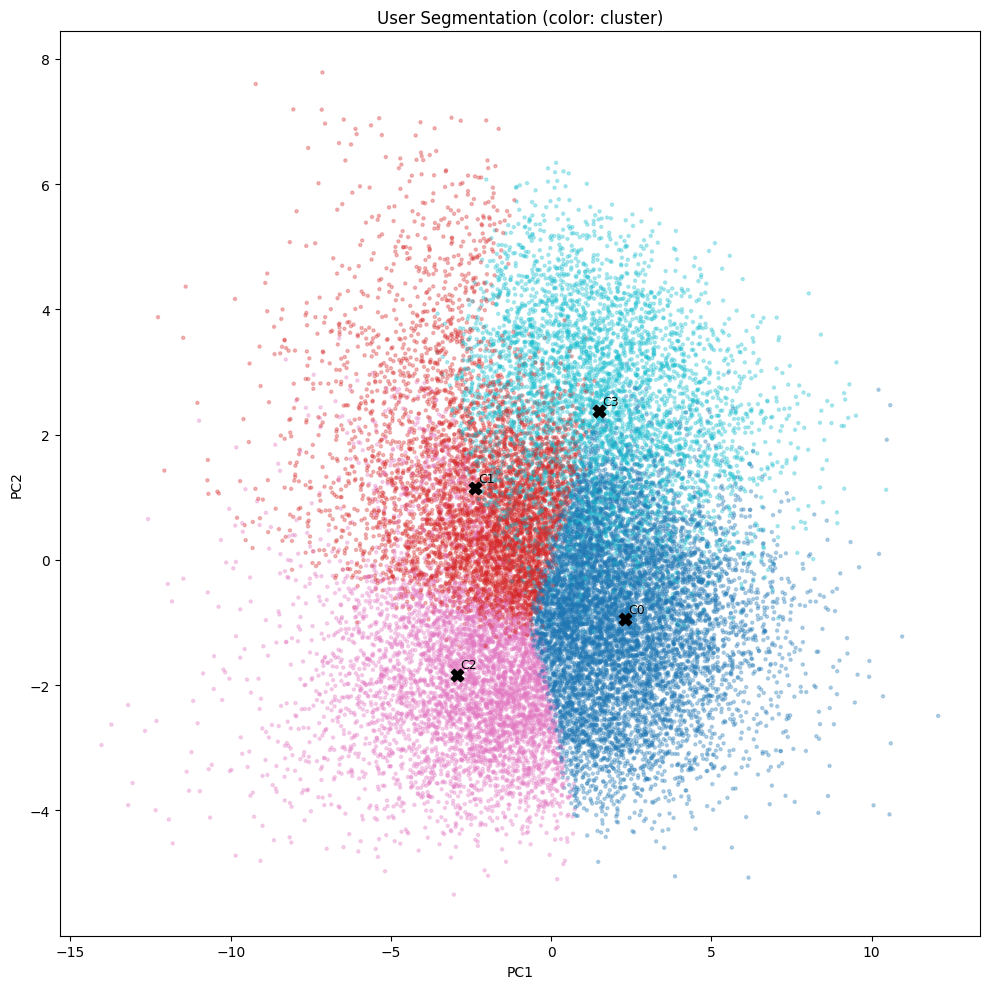

In [50]:
plt.figure(figsize=(10, 10))
plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=cluster_labels,
    s=5,
    alpha=0.3,
    cmap="tab10"
)

for cluster_id, row in cluster_pca_means.iterrows():
    plt.scatter(row["PC1"], row["PC2"], c="black", s=80, marker="X")
    plt.text(row["PC1"] + 0.1, row["PC2"] + 0.1, f"C{cluster_id}", fontsize=9)

plt.title("User Segmentation (color: cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

### Data Exporting

In [51]:
user_features.to_parquet("./data/transactions_eda_s.parquet", index=False)

In [52]:
%reset -f